In [ ]:
!pip install dm_env
! pip install bsuite
! pip install dm-env
! pip install jax
! pip install rlax
! pip install git+https://github.com/deepmind/dm-haiku
! pip install optax
! pip install colabtools

  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-h5c1wy5n
  Running command git clone -q https://github.com/deepmind/dm-haiku /tmp/pip-req-build-h5c1wy5n


In [ ]:
! pip install colabtools

In [ ]:
#@title imports
from google.colab import files
import colabtools
import matplotlib.pyplot as plt
import numpy as np
import itertools
import matplotlib.cm as cm
from matplotlib.patches import Rectangle, Polygon
from IPython.display import clear_output
%matplotlib inline
# from colabtools import adhoc_import
import dm_env
from collections import defaultdict

import functools
import collections

import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax

Environment = collections.namedtuple('Environment', 'step reset')

tmap = jax.tree_multimap
treduce = jax.tree_util.tree_reduce


import functools

from typing import Any, Callable, Mapping, NamedTuple, Tuple

import dm_env
import jax
import jax.numpy as jnp
# import ml_collections
import rlax

tmap = jax.tree_multimap
add = lambda x, y: x + y
tree_add = lambda x, y: tmap(add, x, y)
tree_sub = lambda x, y: tmap(lambda x, y: x - y, x, y)

In [ ]:
#@title TD(lambda) agent

class Agent(NamedTuple):
  step: Callable[..., Any]
  first_step: Callable[..., Any]
  get_v: Callable[..., Any]
  get_mu: Callable[..., Any]
  get_pi: Callable[..., Any]
  get_f: Callable[..., Any]

class AgentState(NamedTuple):

  """Agent state."""
  rng_key: jnp.ndarray
  w_v: Any
  w_z: Any
  w_x: Any
  e_v: Any
  e_x: Any
  e_z: Any
  v_opt_state: Any
  x_opt_state: Any
  z_opt_state: Any
  f_opt_state: Any
  trace_decay: float
  obs: Any
  action: Any
  f: Any
  w_f: Any
  e_f: Any
  followon_decay: Any

def get_config(agent_name, env_id, hyper):
  """Hyper-parameters for this agent."""
  config = {}
  config["init"] = init
  config["cfg"] = {}
  config["cfg"]["discount"] = hyper["discount"]#1.
  config["cfg"]["trace_parameter"] = hyper["lambda"] #0.

  config["cfg"]["v_optimiser_kwargs"] = {}
  config["cfg"]["v_optimiser_kwargs"]["learning_rate"] = hyper["alpha_v"]
  config["cfg"]["v_optimiser_kwargs"]["b1"] = 0.9
  config["cfg"]["v_optimiser_kwargs"]["b2"] = 0.999
  config["cfg"]["v_optimiser_kwargs"]["eps"] = 1e-4
  config["cfg"]["v_optimiser_kwargs"]["momentum"] = 0.9
  config["cfg"]["v_optimiser_kwargs"]["d"] = hyper["d"]

  config["cfg"]["f_optimiser_kwargs"] = {}
  config["cfg"]["f_optimiser_kwargs"]["learning_rate"] = hyper["alpha_f"]
  config["cfg"]["f_optimiser_kwargs"]["b1"] = 0.9
  config["cfg"]["f_optimiser_kwargs"]["b2"] = 0.999
  config["cfg"]["f_optimiser_kwargs"]["eps"] = 1e-4
  config["cfg"]["f_optimiser_kwargs"]["momentum"] = 0.9
  config["cfg"]["f_optimiser_kwargs"]["d"] = hyper["df"]

  config["cfg"]["z_optimiser_kwargs"] = {}
  config["cfg"]["z_optimiser_kwargs"]["learning_rate"] = hyper["alpha_z"]
  config["cfg"]["z_optimiser_kwargs"]["b1"] = 0.9
  config["cfg"]["z_optimiser_kwargs"]["b2"] = 0.999
  config["cfg"]["z_optimiser_kwargs"]["eps"] = 1e-4
  config["cfg"]["z_optimiser_kwargs"]["momentum"] = 0.9
  config["cfg"]["z_optimiser_kwargs"]["d"] = hyper["dz"]

  if env_id == "FiveStateMDP" or env_id == "TabularFiveStateMDP":
    config["cfg"]["pi"] = [0., 1.] # left, right
    config["cfg"]["mu"] = [0.66, 0.33] # left, right
    config["cfg"]["use_special_v_param_init"] = False
  else:
    config["cfg"]["pi"] = [1., 0.] # solid, dashed
    config["cfg"]["mu"] = [1/6, 5/6] # solid, dashed
    config["cfg"]["use_special_v_param_init"] = True

  # Default is the td
  config["cfg"]["use_post_corr"] = False
  config["cfg"]["use_prior_corr"] = False
  config["cfg"]["nonlinear_et"] = False
  config["cfg"]["eta_f"] = 1. # use instantaneous emphasis
  config["cfg"]["eta_x_f"] = 1.
  config["cfg"]["eta_v"] = 1.
  config["cfg"]["eta_z"] = 1.
  config["cfg"]["c_f"] = np.inf
  config["cfg"]["beta"] = hyper["beta"]
  config["cfg"]["positive_followon"] = hyper["positive_followon"]

  config["cfg"]["nonlinear_et"] = False

  if agent_name.endswith("ET(0)"):
    config["cfg"]["eta_v"] = 0. # use expected traces
    config["cfg"]["eta_z"] = 0. # learn expected traces with td
  if agent_name.endswith("ET(1)"):
    config["cfg"]["eta_v"] = 0. # use expected traces
    config["cfg"]["eta_z"] = 1. # learn expected traces with mc

  if agent_name.startswith("Off"):
    config["cfg"]["use_post_corr"] = True

  if agent_name.startswith("ETD") or agent_name.startswith("eet"):
    config["cfg"]["use_post_corr"] = True # use posterior corrections -- importance sampling
    config["cfg"]["use_prior_corr"] = True # use prior corr -- distr corr w emphasis

  if agent_name.startswith("X(1)-"):
    config["cfg"]["use_post_corr"] = True # use posterior corrections -- importance sampling
    config["cfg"]["use_prior_corr"] = True # use prior corr -- distr corr w emphasis
    config["cfg"]["eta_f"] = 0. # use expected emphasis
    config["cfg"]["eta_x_f"] = 1. # learn emphasis through mc

  if agent_name.startswith("X(0)-"):
    config["cfg"]["use_post_corr"] = True # use posterior corrections -- importance sampling
    config["cfg"]["use_prior_corr"] = True # use prior corr -- distr corr w emphasis
    config["cfg"]["eta_f"] = 0. # use expected emphasis
    config["cfg"]["eta_x_f"] = 0. # learn emphasis through td

#   if agent_name.startswith("eta_x"):
#     config["cfg"].use_post_corr = True # use posterior corrections -- importance sampling
#     config["cfg"].use_prior_corr = True # use prior corr -- distr corr w emphasis
#     config["cfg"].eta_f = eta # use expected emphasis with eta else instantaneous emphasis
#     config["cfg"].eta_x_f = 1. # learn emphasis through mc

#   if clipped:
#     config["cfg"]["c_f"] = 1.

  return config

#@title Default title text
def first_step(
    timestep: dm_env.TimeStep,
    agent_state: AgentState,
    policy: Callable[..., Any],
) -> Tuple[Any, AgentState]:
  rng_key, policy_key = jax.random.split(agent_state.rng_key)
  action = policy(policy_key, timestep.observation, agent_state)
  agent_state = agent_state._replace(
      rng_key=rng_key, obs=timestep.observation, action=action)
  return action, agent_state


def step(
    # stateful things
    timestep: dm_env.TimeStep,
    agent_state: AgentState,
    # functions
    x_scale_fn: Callable[..., Any],
    v_scale_fn: Callable[..., Any],
    z_scale_fn: Callable[..., Any],
    x_fn: Callable[..., Any],
    v_fn: Callable[..., Any],
    dv_fn: Callable[..., Any],
    z_fn: Callable[..., Any],
    dzloss_fn: Callable[..., Any],
    policy: Callable[..., Any],
    f_scale_fn: Callable[..., Any],
    f_fn: Callable[..., Any],
    df_fn: Callable[..., Any],
    rho_fn: Callable[..., Any],
    # hyper-parameters
    discount: float,
    trace_parameter: float,
    eta_v: float,
    eta_z: float,
    eta_f: float,
    eta_x_f: float,
    beta: float,
    use_prior_corr: bool,
) -> Tuple[Any, AgentState, Mapping[str, Any]]:  # hyper-parameters
  """One step of the agent."""
  # Map action structure to an int
  action = jax.tree_leaves(agent_state.action)[0]
  reward = timestep.reward
  discount = timestep.discount * discount
  next_obs = timestep.observation
  episode_end = timestep.last()
  (f, e_f, e_v,
   e_x, e_z) = (agent_state.f, agent_state.e_f, agent_state.e_v,
                agent_state.e_x, agent_state.e_z )
  x_f = 0
  del timestep
  trace_decay = agent_state.trace_decay
  (w_v, w_x,
   w_z, w_f)  = (agent_state.w_v, agent_state.w_x,
                    agent_state.w_z, agent_state.w_f)
  obs = agent_state.obs
  f_opt_state = agent_state.f_opt_state
  rng_key, policy_key = jax.random.split(agent_state.rng_key)

  ### Compute values
  # Compute the features x(s)
  x = x_fn(w_x, obs)
  next_x = x_fn(w_x, next_obs)

  # Compute value v(s)
  v = v_fn(w_v, x)
  # import pdb;pdb.set_trace()
  # Compute gradient dv(s)/dw, d log pi(s, a)/dw
  dv_head, dv_torso = dv_fn(w_v, w_x, obs)

  # Compute v(s) at the next time step
  v_next = v_fn(w_v, next_x)

  rho_post, rho_prior = rho_fn(action)
  # Pick new action
  # We do this before updating the weights to avoid forwarding twice
  rng_key, policy_key = jax.random.split(agent_state.rng_key)
  a_next = policy(policy_key, next_obs, agent_state)

  ### Expected trace
  # Compute the expected trace: z(s) ~= E[ γ λ e_{t-1} | S_t=s ]
  z = z_fn(w_z, x)
  # Decay all traces
  e_v, e_z, e_x = tmap(lambda e_i: trace_decay * e_i, (e_v, e_z, e_x))

  # Compute update for the expected trace
  zloss, dw_z = dzloss_fn(w_z, x, e_z)

  # Compute mixture traces η γ λ e_{t-1} + (1 - η) z(S_t)
  # Note: z(S_t) ~= E[ γ λ e_{t-1} | S_t ]
  e_v = tmap(lambda e_i, z_i: eta_v * e_i + (1 - eta_v) * z_i, e_v, z)
  e_z = tmap(lambda e_i, z_i: eta_z * e_i + (1 - eta_z) * z_i, e_z, z)

  f_error = 0
  if use_prior_corr:
    # Decay all traces
    e_f = agent_state.followon_decay * e_f
    f = agent_state.followon_decay * f
    # Compute expected follow-on
    x_f = f_fn(w_f, obs)

    # Learn expected follow-on
    df = df_fn(w_f, w_x, obs)
    f_error = e_f - x_f
    dw_f =  tmap(lambda df_i: f_error * df_i, df)
    dw_f, f_opt_state = f_scale_fn(dw_f, state=f_opt_state)
    w_f = tmap(lambda x, y: x + y, w_f, dw_f)

    # Compute the traces as eta interpolations between TD and MC
    f = eta_f * f + (1 - eta_f) * x_f + 1
    e_f = eta_x_f * e_f + (1 - eta_x_f) * x_f + 1

  # Compute the actual emphasis from the follow-on
  m = trace_parameter + (1 - trace_parameter) * f

  ### Add gradient to traces
  tree_add_weighted = lambda x, y, z: tmap(lambda x, y: x + y * z, x, y)
  e_v = tree_add_weighted(e_v, dv_head, m)
  e_z = tree_add_weighted(e_z, dv_head, m)
  e_x = tree_add_weighted(e_x, dv_torso, m)

  ### Update values
  # Compute term that composes the multi-step λ return
  r_plus_next_v = reward + (1 - trace_parameter) * discount * v_next
  compute_dw = lambda e_i, dv_i: rho_post * (r_plus_next_v * e_i - v * dv_i * m)
  # Compute update for the values
  dw_v, dw_x = tmap(compute_dw, (e_v, e_x), (dv_head, dv_torso))
  dw_v, v_opt_state = v_scale_fn(dw_v, state=agent_state.v_opt_state)
  dw_x, x_opt_state = x_scale_fn(dw_x, state=agent_state.x_opt_state)
  dw_z, z_opt_state = z_scale_fn(dw_z, state=agent_state.z_opt_state)

  # Update weights
  w_v = tmap(lambda x, y: x + y, w_v, dw_v)
  w_x = tmap(lambda x, y: x + y, w_x, dw_x)
  w_z = tree_sub(w_z, dw_z)  # subtract, for gradient descent

  # import pdb; pdb.set_trace()
  # Compute trace decay to apply at the next time step
  trace_decay = discount * trace_parameter
  trace_decay *= 1 - jnp.float32(episode_end)
  followon_decay = rho_prior * jnp.minimum(discount, beta) * (1 - jnp.float32(episode_end))

  # Add some things to log
  log_dict = dict(v=v_next, f=f, e_f=e_f, x_f=x_f,
                  zloss=zloss,
                  rho_prior=rho_prior,
                  rho_post=rho_post,
                  discount=discount, f_td_or_mc_error=f_error,
                  td_error=reward + discount * v_next - v)

  # Assemble new agent state
  agent_state = AgentState(
      rng_key=rng_key,
      w_v=w_v,
      w_z=w_z,
      w_x=w_x,
      w_f=w_f,
      e_v=e_v,
      e_z=e_z,
      e_x=e_x,
      e_f=e_f,
      f=f,
      followon_decay=followon_decay,
      trace_decay=trace_decay,
      v_opt_state=v_opt_state,
      f_opt_state=f_opt_state,
      x_opt_state=x_opt_state,
      z_opt_state=z_opt_state,
      obs=next_obs,
      action=a_next
      )

  return a_next, agent_state, log_dict


def init(
    rng_key: jnp.ndarray,
    network_spec: str,
    action_spec: Any,
    observation_spec: Any,
    discount: float,
    trace_parameter: float,
    v_optimiser_kwargs: Mapping[str, Any],
    f_optimiser_kwargs: Mapping[str, Any],
    z_optimiser_kwargs: Mapping[str, Any],
    pi: Any,
    mu: Any,
    use_prior_corr: bool,
    use_post_corr: bool,
    use_special_v_param_init: bool,
    eta_f: float,
    eta_x_f: float,
    eta_v: float,
    eta_z: float,
    c_f: float,
    beta: float,
    positive_followon: bool,
    nonlinear_et: bool
) -> Tuple[Agent, AgentState]:
  """Initialise TD(λ) agent."""
  # Check the action spec
  action_structure = check_simple_action_spec(action_spec)
  pi = jnp.asarray(pi)
  mu = jnp.asarray(mu)
  # Create random keys
  net_key_x, net_key_v, net_key_z, net_key_f, agent_key = jax.random.split(rng_key, 5)

  # Create Haiku network, and initialise its weights
  x_fn, w_x = create_torso(net_key_x, network_spec, observation_spec)
  # Create haiku action-value network, and initialise its weights
  dummy_observation = dummy(observation_spec)
  dummy_x = x_fn(w_x, dummy_observation)
  if use_special_v_param_init:
    v_fn_, w_v = create_v_head(net_key_v, dummy_x,
                            with_bias=False)
                            # w_init=lambda _1, _2:
                            # np.array([[1.], [1.], [1.], [1.],
                                              # [1.], [10.], [1.]]))
    v_fn = lambda w, x: jnp.squeeze(v_fn_(w, x), -1)
  else:
    v_fn_, w_v = create_v_head(net_key_v, dummy_x,
                            with_bias=False)
    v_fn = lambda w, x: jnp.squeeze(v_fn_(w, x), -1)

  f_fn_, w_f = create_v_head(net_key_f, dummy_x)
  if positive_followon:
    f_fn = lambda w, x: jax.nn.relu(jnp.squeeze(f_fn_(w, x), -1))
  else:
    f_fn = lambda w, x: jnp.squeeze(f_fn_(w, x), -1)

  def rho_fn(action):
    # import pdb; pdb.set_trace()
    rho_prior = pi[action]/mu[action]
    rho_post = rho_prior
    if not use_post_corr:
      rho_post = 1

    return rho_post, rho_prior
    # return jnp.minimum(pi[action]/mu[action], c_f)

  # Create function for the gradients of the v function
  dv_fn = jax.grad(
      lambda w_v, w_x, o: v_fn(w_v, x_fn(w_x, o)), argnums=(0, 1))
  # Create function for the gradients of the v function
  df_fn = jax.grad(lambda w_f, w_x, o: f_fn(w_f, x_fn(w_x, o)))

  # Initialise eligibility traces
  e_v, e_z, e_x = tmap(jnp.zeros_like, (w_v, w_v, w_x))

  (dvdw, _) = dv_fn(w_v, w_x, dummy_observation)
  if nonlinear_et:
    z_fn, w_z = create_nonlinear_z_head(net_key_z, dummy_x, dvdw)
  else:
    z_fn, w_z = create_z_head(net_key_z, dummy_x, dvdw)

  # Create loss function for the expected trace
  def zloss(w_z, x, e):
    total_size = sum([e_i.size for e_i in jax.tree_leaves(e)])
    z = z_fn(w_z, x)
    sum_of_squares = tmap(lambda z_i, e_i: jnp.sum((z_i - e_i)**2), z, e)
    return 0.5 * sum(jax.tree_leaves(sum_of_squares)) / total_size

  # Gradient of the expected trace loss (also outputs the loss, for logging)
  dzloss_fn = jax.value_and_grad(zloss)

  # Create softmax policy
  def policy(rng_key, obs, agent_state):
    # import pdb; pdb.set_trace()
    cpi = jnp.cumsum(mu)
    rnd = jax.random.uniform(rng_key)
    a =  jnp.argmax(cpi > rnd, axis=-1)
    a = jax.tree_unflatten(action_structure, [a])
    return a

  def get_v(all_states, agent_state):
    v_all_states = jax.vmap(lambda obs: v_fn(agent_state.w_v,
                                             x_fn(agent_state.w_x, obs)))(jnp.asarray(all_states))
    return v_all_states

  def get_f(all_states, agent_state):
    f_all_states = jax.vmap(lambda obs: f_fn(agent_state.w_f,
                                             x_fn(agent_state.w_x, obs)))(jnp.asarray(all_states))
    return f_all_states

  def get_mu():
    return mu

  def get_pi():
    return pi

  # Create optimiser (used to transform gradients into updates)
  init_opt, x_adamify = create_optimiser(**v_optimiser_kwargs)
  x_opt_state = init_opt(w_x)
  init_opt, v_adamify = create_optimiser(**v_optimiser_kwargs)
  v_opt_state = init_opt(w_v)

  init_opt, f_adamify = create_optimiser(**f_optimiser_kwargs)
  f_opt_state = init_opt(w_f)

  # Create expected trace optimiser (used to transform gradients into updates)
  init_opt, z_adamify = create_optimiser(**z_optimiser_kwargs)
  z_opt_state = init_opt(w_z)

  # Create initial agent state
  agent_state = AgentState(
      rng_key=agent_key,
      w_v=w_v,
      w_z=w_z,
      w_x=w_x,
      w_f=w_f,
      e_v=e_v,
      e_z=e_z,
      e_x=e_x,
      e_f=1.,
      f=1.,
      trace_decay=0.,
      followon_decay=0.,
      x_opt_state=x_opt_state,
      v_opt_state=v_opt_state,
      z_opt_state=z_opt_state,
      f_opt_state=f_opt_state,
      obs=None,
      action=None)

  # Create the step function, pre-inputting fixed things (e.g., functions,
  # hyper-parameters)
  step_fn = functools.partial(
      step,
      x_scale_fn=x_adamify,
      x_fn=x_fn,
      v_scale_fn=v_adamify,
      v_fn=v_fn,
      dv_fn=dv_fn,
      z_scale_fn=z_adamify,
      z_fn=z_fn,
      dzloss_fn=dzloss_fn,
      f_scale_fn=f_adamify,
      f_fn=f_fn,
      df_fn=df_fn,
      rho_fn=rho_fn,
      policy=policy,
      discount=discount,
      use_prior_corr=use_prior_corr,
      trace_parameter=trace_parameter,
      eta_v=eta_v,
      eta_z=eta_z,
      eta_f=eta_f,
      eta_x_f=eta_x_f,
      beta=beta,
      )

  # Create the reset function, for use at the beginning of episodes.
  first_step_fn = functools.partial(first_step, policy=policy)

#   agent = Agent(step=step_fn, first_step=first_step_fn,
#                 get_v=get_v, get_mu=get_mu,
#                 get_pi=get_pi, get_f=get_f)
  agent = Agent(step=jax.jit(step_fn), first_step=jax.jit(first_step_fn),
                get_v=jax.jit(get_v), get_mu=jax.jit(get_mu),
                get_pi=jax.jit(get_pi), get_f=jax.jit(get_f))
  return agent, agent_state

In [ ]:
#@title Aux functions: smooth, create_optimiser...
# def smooth(x, m):
#   n = max([1, len(x)//m])
#   return np.convolve(x, np.ones(n)/n, 'valid')

def smooth(x, m):
  if m <= 1:
    return x
  n = max([1, len(x)//m])
  return np.convolve(x, np.ones(n)/n, 'valid')

def check_simple_observation_spec(observation_spec):
  specs = jax.tree_leaves(observation_spec)
  if len(specs) > 1:
    raise ValueError('Complex observations not supported. Found observation '
                     f'spec: {observation_spec}')


def check_simple_action_spec(action_spec):
  specs, structure = jax.tree_flatten(action_spec)
  all_disc = np.all(list(spec.dtype in [np.int32, np.int64] for spec in specs))
  if len(specs) > 1 or not all_disc:
    raise ValueError('Learning algorithms can currently only support '
                     'environments with a single discrete action. Action spec: '
                     f'{action_spec}')
  return structure


def create_optimiser(b1, b2, eps, learning_rate, momentum, d):
    def schedule_fn(t):
      return (1/(t+1))**d
    if learning_rate is None:
      return optax.chain(
        # optax.trace(momentum, nesterov=False),
        optax.scale_by_schedule(schedule_fn),
        # optax.scale(learning_rate),
      )
    else:
        return optax.chain(
            # optax.trace(momentum, nesterov=False),
            # optax.scale_by_adam(b1=b1, b2=b2, eps=eps),
            optax.scale(learning_rate),
        )

def dummy(observation_spec):
  return jax.tree_map(
      lambda x: jnp.zeros(x.shape, dtype=x.dtype), observation_spec)

def _get_num_actions(action_spec):
  check_simple_action_spec(action_spec)
  return jax.tree_leaves(action_spec)[0].num_values


In [ ]:
#@title FiveStateMDP
from typing import Any, Dict

from bsuite.environments import base

import dm_env
from dm_env import specs
import numpy as np
class FiveStateMDP(base.Environment):
  """FiveStateMDP environment."""

  def __init__(self, seed, obs_type="features"):
    """Builds a FiveStateMDP environment with 5 state and 2 actions.

    Args:
      seed: int
    """
    super().__init__()

    self._nrng = np.random.RandomState(seed)
    self._n_states = 5
    self._n_actions = 2
    self._position = 2
    # S x A
    # self._mu = np.asarray(, dtype=np.float32)
    # self._mu_all_states = np.asarray(self._n_states * [self._mu])
    # self._pi = np.asarray([0., 1.], dtype=np.float32)
    # self._pi = np.asarray(self._n_states * [self._pi])
    # S x n_features
    if obs_type == "onehot":
      self._x = np.eye(self._n_states)
      self._n_features = self._n_states
    else:
      self._x = np.asarray(
                [[1.,0.,0.],
                [1.,1.,0.],
                [0.,1.,0.],
                [0.,1.,1.],
                [0.,0.,1.]])
      self._n_features = 3
    # A x S x S
    self._p = np.asarray([[[1., 0., 0., 0., 0.], # Left
                           [1., 0., 0., 0., 0.],
                           [0., 1., 0., 0., 0.],
                           [0., 0., 1., 0., 0.],
                           [0., 0., 0., 1., 0.]],
                          [[0., 1., 0., 0., 0.], # Right
                           [0., 0., 1., 0., 0.],
                           [0., 0., 0., 1., 0.],
                           [0., 0., 0., 0., 1.],
                           [0., 0., 0., 0., 1.]]])
    # A x S x S
    self._r = np.ones((self._n_actions, self._n_states, self._n_states))
    self._discounts = np.asarray([0, 1, 1, 1, 0])
    # self._true_v_pi = np.asarray([4, 3, 2, 1, 1], dtype=np.float64)

  def _get_observation(self):
    obs = self._x[self._position]
    return obs

  def get_all_states(self):
    return self._x

  def get_q_pi(self, pi, discount=None):
    pi = np.asarray(self._n_states * [pi])
    discount = 1. if discount is None else discount
    discounts = np.full((self._n_states), discount)
    discounts *= self._discounts
    disc_p = np.einsum('kij, j->kij', self._p, discounts)
    disc_ppi = np.einsum('kij, jm->ikjm', disc_p, pi)
    disc_ppi_flat = np.reshape(disc_ppi, (self._n_states * self._n_actions, self._n_states * self._n_actions))
    rpi = np.einsum("kij, kij->ik", self._r, self._p)
    rpi_flat = np.reshape(rpi, (-1))
    q = np.linalg.solve(np.eye(self._n_states * self._n_actions) - disc_ppi_flat, rpi_flat)
    q = np.reshape(q, (self._n_states, self._n_actions))
    return q

  def get_sa_stationary(self, pi, discount=None):
    pi = np.asarray(self._n_states * [pi])
    discount = 1. if discount is None else discount
    discounts = np.full((self._n_states), discount)
    # discounts *= self._discounts
    disc_p = np.einsum('kij, j->kij', self._p, discounts)
    disc_ppi = np.einsum('kij, ik->ij', disc_p, pi)
    A = np.eye(self._n_states) - disc_ppi
    A = np.vstack((A.T, np.ones(self._n_states)))
    b = np.matrix([0] * self._n_states + [1]).T
    d_pi = np.linalg.lstsq(A, b)[0]
    d_pi = np.array(d_pi.T)[0]
    d_sa_pi = np.einsum('i, ik->ik', d_pi, pi)
    return d_sa_pi

#   def get_stationary(self, pi, discount=None):
#     pi = np.asarray(self._n_states * [pi])
#     discount = 1. if discount is None else discount
#     discounts = np.full((self._n_states), discount)
#     # discounts *= self._discounts
#     disc_p = np.einsum('kij, j->kij', self._p, discounts)
#     disc_ppi = np.einsum('kij, ik->ij', disc_p, pi)
#     A = np.eye(self._n_states) - disc_ppi
#     A = np.vstack((A.T, np.ones(self._n_states)))
#     b = np.matrix([0] * self._n_states + [1]).T
#     d_pi = np.linalg.lstsq(A, b)[0]
#     d_pi = np.array(d_pi.T)[0]
#     return d_pi
  def get_stationary(self, pi, discount=1.0, T=100):
    dS = self._n_states
    dA = self._n_actions
    state_visitation = np.zeros((dS, 1))
    state_visitation[2] = 1
    pi = np.asarray(self._n_states * [pi])
    sa_visit_t = np.zeros((dS, dA, T))

    norm_factor = 0.0
    for i in range(T):
        sa_visit = state_visitation * pi
        cur_discount = (discount ** i)
        sa_visit_t[:, :, i] = cur_discount * sa_visit
        norm_factor += cur_discount
        # sum-out (SA)S
        new_state_visitation = np.einsum('ij,jik->k', sa_visit, self._p)
        state_visitation = np.expand_dims(new_state_visitation, axis=1)
    d_sa = np.sum(sa_visit_t, axis=2) / norm_factor
    d_s = np.sum(d_sa * pi, axis=-1)
    return d_s

  def get_v_pi(self, pi, discount=None):
    discount = 1. if discount is None else discount
    discounts = np.full((self._n_states), discount)
    discounts *= self._discounts
    pi = np.asarray(self._n_states * [pi])
    disc_p = np.einsum('kij, j->kij', self._p, discounts)
    disc_ppi = np.einsum('kij, ik->ij', disc_p, pi)
    rpi = np.einsum('kij, kij, ik->i', self._r, self._p, pi)
    v = np.linalg.inv(np.eye(self._n_states) - disc_ppi).dot(rpi)
    return v

  def get_f_pi(self, pi, mu, discount=None):
    discount = 1. if discount is None else discount
    discounts = np.full((self._n_states), discount)
    discounts *= self._discounts
    pi = np.asarray(self._n_states * [pi])
    d_mu = self.get_stationary(mu, discount)
    disc_p = np.einsum('kij, j->kij', self._p, discounts)
    disc_ppi = np.einsum('kij, ik->ij', disc_p, pi)
    rpi = np.einsum('kij, kij, ik->i', self._r, self._p, pi)
    f = d_mu.dot(np.linalg.inv(np.eye(self._n_states) - disc_ppi))
    return f

  # def get_stationary(self, pi, discount=None):
  #   pi = np.asarray(self._n_states * [pi])
  #   discount = 1. if discount is None else discount
  #   discounts = np.full((self._n_states), discount)
  #   # discounts *= self._discounts
  #   disc_p = np.einsum('kij, j->kij', self._p, discounts)
  #   disc_ppi = np.einsum('kij, ik->ij', disc_p, pi)
  #   A = np.eye(self._n_states) - disc_ppi
  #   A = np.vstack((A.T, np.ones(self._n_states)))
  #   b = np.matrix([0] * self._n_states + [1]).T
  #   d_pi = np.linalg.lstsq(A, b)[0]
  #   d_pi = np.array(d_pi.T)[0]
  #   return d_pi

  # def get_v_pi(self, pi, discount=None):
  #   discount = 1. if discount is None else discount
  #   discounts = np.full((self._n_states), discount)
  #   discounts *= self._discounts
  #   pi = np.asarray(self._n_states * [pi])
  #   disc_p = np.einsum('kij, j->kij', self._p, discounts)
  #   disc_ppi = np.einsum('kij, ik->ij', disc_p, pi)
  #   rpi = np.einsum('kij, kij, ik->i', self._r, self._p, pi)
  #   v = np.linalg.inv(np.eye(self._n_states) - disc_ppi).dot(rpi)
  #   return v

  def _reset(self) -> dm_env.TimeStep:
    self._position = 2
    observation = self._get_observation()
    return dm_env.restart(observation)

  def _step(self, action: int) -> dm_env.TimeStep:
    new_position = self._nrng.choice(range(self._n_states),
                                     p=self._p[action][self._position])
    reward = self._r[action][self._position][new_position]
    self._position = new_position
    next_observation = self._get_observation()
    return dm_env.transition(reward=reward,
                             discount=self._discounts[self._position],
                             observation=next_observation)

  def observation_spec(self):
    return specs.Array(shape=(self._n_features,), dtype=np.float32)

  def action_spec(self):
    return specs.DiscreteArray(self._n_actions, name='action')

  def _save(self, observation):
    self._raw_observation = (observation * 255).astype(np.uint8)

  @property
  def optimal_return(self):
    # Returns the maximum total reward achievable in an episode.
    return 10

  def bsuite_info(self) -> Dict[str, Any]:
    return {}


In [ ]:
#@title env test
env = FiveStateMDP(42)
v_pi = env.get_v_pi(pi=[1, 0])

d_mu = env.get_stationary(pi=[0.66, 0.33])
print(env.get_stationary(pi=[0, 1]))
print(d_mu)
pi_ = np.asarray(env._n_states * [[0,1]])
disc_p = np.einsum('kij, j->kij', env._p, env._discounts)
disc_ppi = np.einsum('kij, ik->ij', disc_p, pi_)
print(d_mu.dot(np.linalg.inv(np.eye(env._n_states) - disc_ppi)))

[0.   0.   0.01 0.01 0.98]
[0.16932769 0.08878801 0.05064273 0.02447705 0.0119599 ]
[0.16932769 0.2581157  0.30875843 0.33323549 0.0119599 ]


In [ ]:
#@title runner
def run(
    number_of_episodes = -1,
    number_of_steps = 1e3,
    log_every_steps = 10,
    log_every_episodes = 10,
    seeds=1,
    hyperparams=None,
    custom_hyperparams=None,
    envs = ['FiveStateMDP'],
    network="linear",
    verbose=False,
    agents=[("td", False, None)],
    ):

  stats_keys = ["td_error", "rewards", "value_errors",
                            "values", "f_td_or_mc_errors",
                            "f_exp_errors", "zloss", "rhos_post",
                            "f_var_errors", "value_weights"]
  all_envs_stats = defaultdict(list)

  for env_id in envs:
    agents_stats = defaultdict(list)
    hyper = {}
    for agent_name in agents:
      agents_params = {}
      for k, v in hyperparams.items():
        agents_params[k] = v
        if agent_name in custom_hyperparams.keys() and\
          k in custom_hyperparams[agent_name].keys():
          agents_params[k] = custom_hyperparams[agent_name][k]
    #   import pdb;pdb.set_trace()
      for hyper_values in itertools.product(*agents_params.values()):
        seeds_stats = defaultdict(list)
        for v, k in zip(hyper_values, agents_params.keys()):
          hyper[k] = v
        for s in range(seeds):
          stats = defaultdict(list)

          agent_config = get_config(agent_name, env_id=env_id,
                                    hyper=hyper)
          if env_id == "FiveStateMDP":
            env = FiveStateMDP(seed=4321+s)
          elif env_id == "TabularFiveStateMDP":
            env = FiveStateMDP(seed=4321+s, obs_type="onehot")
          else:
            env = BairdMDP(seed=4321+s)

          agent, agent_state = agent_config`["init"](
              rng_key=jax.random.PRNGKey(4321+s),
              network_spec=(network or env_id),
              action_spec=env.action_spec(),
              observation_spec=env.observation_spec(),
              **agent_config["cfg"])

          timestep = None
          episode_timesteps = 0
          t = 0
          ep = 0
          ep_return = 0

          while(True):
            # Reset environment and pick first action
            if not timestep or timestep.last():
              timestep = env.reset()
              action, agent_state = agent.first_step(timestep, agent_state)
              all_states = env.get_all_states()
              v_pi = agent.get_v(all_states, agent_state)
              true_v_pi = env.get_v_pi(agent.get_pi())
              d_mu = env.get_stationary(agent.get_mu())
              true_f_pi = env.get_f_pi(agent.get_pi(), agent.get_mu())
            #   print(true_v_pi)
            #   print(v_pi)
            #   print(d_mu)
            #   print(f'Initial value function v(w_0) is {v_pi}')
              # exit(0)
            # import pdb;pdb.set_trace()
            # Take the current action in the environment
            timestep = env.step(action)
            # Step the agent (learns, and gives new action)
            action, agent_state, log_dict = agent.step(
                timestep=timestep, agent_state=agent_state)

            episode_timesteps += 1
            ep_return += timestep.reward
            t += 1

            if timestep.last():
              ep_timesteps.append(episode_timesteps)
              episode_timesteps = 0
              ep += 1
              returns.append(ep_return)
              ep_return = 0

            if timestep.last() or \
              (number_of_steps > -1 and t % log_every_steps == 0):
                # Log instantaneous reward
                # print(log_dict["td_error"])
                stats["rewards"].append(timestep.reward)
                # Log td errors
                stats["td_error"].append(log_dict["td_error"])
                # Log the values/action-values
                stats["values"].append(log_dict["v"])
                # Log the td or the mc error for the follow-on trace
                stats["f_td_or_mc_errors"].append(log_dict["f_td_or_mc_error"])
                stats["zloss"].append(log_dict["zloss"])
                # Log value error
                v_pi = agent.get_v(all_states, agent_state)
                # print(v_pi)
                ve = np.average((true_v_pi - v_pi)**2, weights=d_mu)
                stats["value_errors"].append(ve)
                f_pi = agent.get_f(all_states, agent_state)
                fe = np.average((true_f_pi - f_pi)**2, weights=d_mu)
                stats["f_exp_errors"].append(fe)
                # Log the instantaneous variance
                f_var_e = (log_dict["f"] - f_pi[env._position])**2
                stats["f_var_errors"].append(f_var_e)
                # w = np.asarray(agent_state.w["linear"]["w"].reshape((-1)))
                # value_weights.append(w)
                stats["rhos_prior"].append(log_dict["rho_prior"])
                stats["rhos_post"].append(log_dict["rho_post"])

            # if t % log_every == 0 and verbose:
            # #   print(f'steps: {t:10}',
            # #         f', f_mc_error: {log_dict["f_error"]}',
            # #                 f', f: {log_dict["f"]}',
            # #                 f', e_f: {log_dict["e_f"]}',
            # #                 f', x_f: {log_dict["x_f"]}',
            # #                 )
            #     recent_rhos = np.mean(rhos[-log_every:])
            #     recent_avg_reward = np.mean(rewards[-log_every:])
            #     recent_avg_td_error = np.mean(td_errors[-log_every:])
            #     recent_ve = np.mean(value_errors[-log_every:])
            #     recent_values = np.mean(values[-log_every:])
            #     recent_f_td_or_mc_errors = np.mean(f_errors[-log_every:])
            #     recent_f_exp_errors = np.mean(f_errors[-log_every:])
            #     recent_f_var_errors = np.mean(f_errors[-log_every:])
            #     print(f'steps: {t:10}',
            #           f', mean last {log_every} avg reward: {recent_avg_reward}'
            #           f', td errors: {recent_avg_td_error}',
            #           f', ve: {recent_ve}',
            #           f', values: {recent_values}',
            #           f', rhos: {recent_rhos}')
            if (number_of_steps > -1 and t > number_of_steps) or \
            (number_of_episodes > -1 and ep > number_of_episodes):
              break

          for k in stats_keys:
            seeds_stats[k].append(stats[k])

        for k in stats_keys:
            agents_stats[k].append(seeds_stats[k])
    for k in stats_keys:
        all_envs_stats[k].append(agents_stats[k])

  return all_envs_stats

In [ ]:
#@title nets
def dummy(observation_spec):
  return jax.tree_map(
      lambda x: jnp.zeros(x.shape, dtype=x.dtype), observation_spec)

def linear_net(observation_spec, with_bias=True, w_init=None):
  check_simple_observation_spec(observation_spec)

  def fun(obs, num_actions):
    if w_init is not None:
      q = hk.Linear(num_actions, with_bias=with_bias, w_init=w_init)
    else:
      q = hk.Linear(num_actions, with_bias=with_bias)
    return q(obs)
  return fun


def mlp_net(observation_spec):
  check_simple_observation_spec(observation_spec)

  def fun(obs, num_actions):
    net = hk.Sequential([
        hk.Linear(20),
        jax.nn.relu,
        # hk.Linear(20),
        # jax.nn.relu,
    ])
    x = net(obs)
    q = hk.Linear(num_actions)
    return q(x)
  return fun

def mlp2_net(observation_spec):
  check_simple_observation_spec(observation_spec)

  def fun(obs, num_actions):
    net = hk.Sequential([
        hk.Linear(20),
        jax.nn.relu,
        hk.Linear(20),
        jax.nn.relu,
    ])
    x = net(obs)
    q = hk.Linear(num_actions)
    return q(x)
  return fun

def mlp_linear_torso_net(observation_spec):
  check_simple_observation_spec(observation_spec)

  def fun(obs):
    return obs
  return fun

def mlp_torso_net(observation_spec):
  check_simple_observation_spec(observation_spec)

  def fun(obs):
    net = hk.Sequential([
        hk.Linear(20),
        jax.nn.relu,
        # hk.Linear(20),
        # jax.nn.relu,
    ])
    return net(obs)
  return fun

def mlp2_torso_net(observation_spec):
  check_simple_observation_spec(observation_spec)

  def fun(obs):
    net = hk.Sequential([
        hk.Linear(20),
        jax.nn.relu,
        hk.Linear(20),
        jax.nn.relu,
    ])
    return net(obs)
  return fun

def create_torso(
    rng_key: jnp.ndarray,
    network_spec: str,
    observation_spec: Any,
):
  if network_spec == "linear":
    net = mlp_linear_torso_net(observation_spec)
  elif network_spec == "mlp":
    net = mlp_torso_net(observation_spec)
  else:
    net = mlp2_torso_net(observation_spec)

  init, apply_fn = hk.without_apply_rng(hk.transform(net))
  dummy_observation = jax.tree_map(lambda x: jnp.zeros(x.shape, dtype=x.dtype),
                                   observation_spec)
  w = init(rng_key, obs=dummy_observation)
  return apply_fn, w

def create_q_head(
    rng_key: jnp.ndarray,
    dummy_x: Any,
    action_spec: Any,
):
  """Pick and initialise a haiku network."""
  num_actions = _get_num_actions(action_spec)

  init, q_fn = hk.without_apply_rng(
      hk.transform(functools.partial(q_head, num_actions=num_actions)))

  w = init(rng_key, x=dummy_x)
  return q_fn, w

def create_v_head(
    rng_key: jnp.ndarray,
    dummy_x: Any,
    with_bias: bool = True,
    w_init: Any = None
):
  """Pick and initialise a haiku network."""
  init, v_fn = hk.without_apply_rng(
      hk.transform(functools.partial(v_head,
                                     with_bias=with_bias,
                                     w_init=w_init)))

  w = init(rng_key, x=dummy_x)
  return v_fn, w

def create_nonlinear_z_head(
    rng_key: jnp.ndarray,
    dummy_x: Any,
    trace: Any,
):
  """Pick and initialise a haiku network."""
  init_fn, z_fn = hk.without_apply_rng(
      hk.transform(functools.partial(_non_linear_z_head, trace=trace)))

  w_z = init_fn(rng_key, x=dummy_x)
  return z_fn, w_z

def create_z_head(
    rng_key: jnp.ndarray,
    dummy_x: Any,
    trace: Any,
):
  """Pick and initialise a haiku network."""
  init_fn, z_fn = hk.without_apply_rng(
      hk.transform(functools.partial(_z_head, trace=trace)))

  w_z = init_fn(rng_key, x=dummy_x)
  return z_fn, w_z

def _non_linear_z_head(x, trace):
  """Creates a network head for the expected eligibility trace.

  The small network learns to estimate the gradients of the q-head network.

  Args:
      x: input of the expected trace net,
      trace: the trace,

  Returns:
      The expected trace z.
  """
  trace_flat, trace_tree = jax.tree_flatten(trace)

  expected_traces = []
  for trace_i in trace_flat:
    net = hk.Sequential([
        hk.Linear(20),
        jax.nn.relu,
        # hk.Linear(20),
        # jax.nn.relu,
    ])
    x = net(x)
    x = hk.Linear(np.prod(trace_i.shape))(x)
    x = jnp.reshape(x, trace_i.shape)
    expected_traces.append(x)

  z = jax.tree_unflatten(trace_tree, expected_traces)
  return z

def _z_head(x, trace):
  """Creates a network head for the expected eligibility trace.

  The small network learns to estimate the gradients of the q-head network.

  Args:
      x: input of the expected trace net,
      trace: the trace,

  Returns:
      The expected trace z.
  """
  trace_flat, trace_tree = jax.tree_flatten(trace)

  expected_traces = []
  for trace_i in trace_flat:
    x = hk.Linear(np.prod(trace_i.shape))(x)
    x = jnp.reshape(x, trace_i.shape)
    expected_traces.append(x)

  z = jax.tree_unflatten(trace_tree, expected_traces)
  return z

def q_head(x, num_actions):
  q = hk.Linear(num_actions)
  return q(x)

def v_head(x, with_bias=None, w_init=None):
  if w_init is not None:
    v = hk.Linear(1, with_bias=with_bias, w_init=w_init)
  else:
    v = hk.Linear(1, with_bias=with_bias)
  return v(x)


def create_v_net(
    rng_key: jnp.ndarray,
    network_spec: str,
    observation_spec: Any,
    with_bias: bool = True,
    w_init: Any = None
):
  """Pick and initialise a haiku network."""

  # Usually this is a genrl environment id, so we extract domain name and use
  # that to select an agent network.
  if network_spec == "linear":
    net = linear_net(observation_spec, with_bias, w_init)
  else:
    net = mlp_net(observation_spec, with_bias, w_init)

  init, v_fn = hk.without_apply_rng(
      hk.transform(functools.partial(net, num_actions=1)))
  dummy_observation = jax.tree_map(lambda x: jnp.zeros(x.shape, dtype=x.dtype),
                                   observation_spec)
  w = init(rng_key, obs=dummy_observation)
  return v_fn, w

def create_net(
    rng_key: jnp.ndarray,
    network_spec: str,
    observation_spec: Any,
    action_spec: Any,
    with_bias: bool = True,
):
  """Pick and initialise a Haiku network."""

  # Usually this is a genrl environment id, so we extract domain name and use
  # that to select an agent network.
  if network_spec == "linear":
    net = linear_net(observation_spec, with_bias)
  else:
    net = mlp_net(observation_spec, with_bias)
  num_actions = _get_num_actions(action_spec)

  init, q_fn = hk.without_apply_rng(
      hk.transform(functools.partial(net, num_actions=num_actions)))
  dummy_observation = jax.tree_map(lambda x: jnp.zeros(x.shape, dtype=x.dtype),
                                   observation_spec)
  w = init(rng_key, obs=dummy_observation)
  return q_fn, w


In [ ]:
#@title Plot lims
fig_lims = {
            "FiveStateMDP": {"td_error": [-50, 50],
                "value_error": [0, 50],
                "value": [0, 50],
                "f_td_or_mc_error": [-1000, 10000],
                "f_exp_error": [0, 10000],
                "f_var_error": [0, 10000],
                "value_weights": [-10000, 10000],
                "zloss": [-5000, 1000],
                "return": [0, 5000],
                "rewards": [0, 5000],
                "ep_timesteps": [0, 10000],
                "rhos_post": [-5000, 5000],
                },
            "TabularFiveStateMDP": {"td_error": [-5000, 5000],
                "value_error": [-5000, 5000],
                "rewards": [-5000, 5000],
                "value": [-5000, 5000],
                "return": [-5000, 5000],
                "zloss": [-5000, 5000],
                "ep_timesteps": [-5000, 5000],
                "f_td_or_mc_error": [-5000, 5000],
                "f_exp_error": [-5000, 5000],
                "f_var_error": [-5000, 5000],
                "value_weights": [-5000, 5000],
                "rhos_post": [-5000, 5000],
                },
}

In [ ]:
def save_fig_pdf(fig, name):
  from colabtools import fileedit
  file = '/tmp/{}.pdf'.format(name)
  with open(file, 'wb') as f:
    fig.savefig(f, facecolor='none', edgecolor='none', format='pdf', bbox_inches="tight")
  fileedit.download_file(file) # this uses the python interface to %download_file

def save_fig_png(fig, name):
  from colabtools import fileedit
  file = '/tmp/{}.pdf'.format(name)
  with open(file, 'wb') as f:
    fig.savefig(f, facecolor='none', edgecolor='none', format='png', bbox_inches="tight")
  fileedit.download_file(file) # this uses the python interface to %download_file

#@title plotting
COLORS = (

'#dfc27d',
# '#bf812d',
'#01665e',
'#80cdc1',

# '#f6e8c3',
# '#c7eae5',
# '#35978f',
'#8c510a',

# # '#f6e8c3',
# # '#c7eae5',
# '#80cdc1',
# # '#35978f',
# '#01665e',

# '#8c510a',
# '#bf812d',
# '#dfc27d',
# '#a6cee3',
#     '#8c510a',
# # '#bf812d',
# '#dfc27d',
# # '#f6e8c3',
# '#c7eae5',
# # '#80cdc1',
# '#35978f',
# # '#01665e',
# # '#a6cee3',
#     '#8c510a',
# # '#bf812d',
# '#dfc27d',
# # '#f6e8c3',
# '#c7eae5',
# '#80cdc1',
# # '#35978f',
# '#01665e',
# '#253494',
# '#2c7fb8',
# '#41b6c4',
# '#7fcdbb',
# '#c7e9b4',
# '#ffffcc',
)
def make_axis_nice(ax, fontsize):
  ax.xaxis.label.set_fontsize(fontsize)
  ax.yaxis.label.set_fontsize(fontsize)
  ax.tick_params(axis="both", which="both", bottom="off", top="off",
                 labelbottom="on", left="off", right="off", labelleft="on")
  ax.spines["top"].set_visible(False)
  ax.spines["bottom"].set(visible=True, color='black', lw=2)
  ax.spines["right"].set_visible(False)
  ax.spines["left"].set(visible=True, color='black', lw=2)
  ax.get_xaxis().tick_bottom()
  ax.get_yaxis().tick_left()
  ax.xaxis.grid(False)
  ax.yaxis.grid(linestyle="--", lw=0.5, color="black", alpha=0.25)
  ax.tick_params(labelsize=fontsize)

def add_subplot(env_id, data, num_ticks,
                seeds, agents, data_key, subplot_title, description, ax, smoothing=1,
                fontsize=20, custom_hyperparams=None, hyperparams=None):
  i = 0

  for agent in agents:
    agents_params = {}
    for k, v in hyperparams.items():
        agents_params[k] = v
        if agent in custom_hyperparams.keys() and\
         k in custom_hyperparams[agent].keys():
          agents_params[k] = custom_hyperparams[agent][k]
    hyper = {}
    # print(agents_params.values())
    for hyper_values in itertools.product(*agents_params.values()):
      for v, k in zip(hyper_values, agents_params.keys()):
            hyper[k] = v
    #   print(hyper_values)
      if len(data[i]) == 0:
        continue

      mean = np.mean(data[i], axis=0)
      data_std = np.std(data[i], axis=0)
    #   if len(mean) <= smoothing:
    #       continue

      mean = smooth(mean, smoothing)[:1000]

      x_mean = range(0, len(mean) * smoothing, smoothing)
      data_std = smooth(data_std, smoothing)[:1000]

      if "alpha_v_f" in list(hyper.keys()):
        hyper["alpha_v"] = hyper["alpha_v_f"][0]
        hyper["alpha_f"] = hyper["alpha_v_f"][1]
      agent_label = (r'{}'.format(agent) +
                       "{}{}{}{}".format(
                        r',$\alpha_v={}$'.format(hyper["alpha_v"]) if hyper["alpha_v"] is not None and ("alpha_v" in list(agents_params.keys()) and len(agents_params["alpha_v"]) > 1 or "alpha_v" not in list(agents_params.keys())) else r', $d={}$'.format(hyper["d"]) if hyper["d"] is not None and len(agents_params["d"]) > 1 else '',
                        r',$\alpha_z={}$'.format(hyper["alpha_z"]) if hyper["alpha_z"] is not None and len(agents_params["alpha_z"]) > 1 else r', $dz={}$' if hyper['dz'] is not None and len(agents_params["dz"]) > 1 else '',
                        r',$\alpha_f={}$'.format(hyper["alpha_f"]) if hyper["alpha_f"] is not None and ("alpha_f" in list(agents_params.keys()) and len(agents_params["alpha_f"]) > 1 or "alpha_f" not in list(agents_params.keys())) else r', $df={}$'.format(hyper["df"]) if hyper["df"] is not None and len(agents_params["df"]) > 1 else '',
                        r',$\beta={}$'.format(hyper["beta"]) if hyper["beta"] < 100 and len(agents_params["beta"]) > 1 else ''))
      ax.plot(x_mean, mean,
                ':' if agent.startswith('X') else '-' ,
                lw=4,
                color=COLORS[i % len(COLORS)], alpha=1.,
                label=agent_label)
      print(f"{agent_label}_{i}_{COLORS[i % len(COLORS)]}")
    #   import pdb;pdb.set_trace()
      ax.fill_between(x=x_mean, y1=mean - data_std / np.sqrt(seeds),
                      y2=mean +  data_std / np.sqrt(seeds),
              color=COLORS[i % len(COLORS)], alpha=0.2)
    #   for s in range(seeds):
    #     if len(data[i][s]) <= smoothing:
    #       continue
    #     ax.plot(smooth(data[i][s], smoothing),
    #             '-', lw=3,
    #             color=COLORS[i % len(COLORS)], alpha=0.2)
      i += 1
#   ax.set_title(subplot_title, fontdict=dict(fontsize=fontsize))
  make_axis_nice(ax, fontsize)
  ax.set_xlabel("Steps")
  ax.set_ylabel(subplot_title)
#   ax.set_yscale('log')
  ax.set_title(description, fontsize=fontsize)

#   ylim = ax.get_ylim()
#   d = (np.minimum(fig_lims[env_id][data_key][1], ylim[1]) -
#         np.maximum(fig_lims[env_id][data_key][0], ylim[0])) / 100
#   ax.set_ylim(np.maximum(fig_lims[env_id][data_key][0], ylim[0]) - d,
#           np.minimum(fig_lims[env_id][data_key][1], ylim[1]) + d)
  return ax

def plot_statistics(env_id, agents,
                    statistics,
                    custom_hyperparams,
                    hyperparams,
                    seeds, num_ticks=5,
                    smoothing=1,
                    fontsize=20,
                    cols=4,
                    rows=4,
                    legend_bbox_to_anchor=(0., 1.05),
                    legend_ncol=6,
                    legend_loc='upper left',
                    ):
  fig = plt.figure(figsize=(cols*5, rows*4))
#   fig.suptitle(env_id, fontsize=fontsize)
  stats_index = 1
  handle_list = []
  label_list = []
  for stats_key, stats in statistics.items():
    if len(stats["data"]) > 0:
      ax = plt.subplot(rows, cols, stats_index)
      ax = add_subplot(agents=agents, env_id=env_id, smoothing=smoothing, hyperparams=hyperparams,
                  seeds=seeds, description=stats["description"],
                   custom_hyperparams=custom_hyperparams,
                  ax=ax, fontsize=fontsize, data=stats["data"], subplot_title=stats["y"],
                  data_key=stats_key, num_ticks=num_ticks)
      handles, labels = ax.get_legend_handles_labels()
      for handle, label in zip(handles, labels):
          if label not in label_list:
            handle_list.append(handle)
            label_list.append(label)
      stats_index += 1
      fig.add_subplot(ax)
#   print(label_list)
  fig.legend(handle_list, label_list,
             loc=legend_loc, prop={'size': fontsize},
             bbox_to_anchor=legend_bbox_to_anchor,
             frameon=False,
            labelspacing=0.5,
            columnspacing=0.5,
            handletextpad=0.5,
            handlelength=2.,
             fancybox=False, shadow=False,
             ncol=legend_ncol)#, fancybox=True, shadow=True)
#   fig.tight_layout(pad=5)
#   fig.subplots_adjust(top=0.80)
  with open("stats.png", 'wb') as f:
    fig.savefig(f, format='pdf', bbox_inches="tight")
  files.download("stats.png")
#
#   fig.savefig(, facecolor='none', edgecolor='none', format='pdf', bbox_inches="tight")
#   fileedit.download_file(file) # this uses the python interface to %download_file

#   save_fig_pdf(fig, 'graph')

In [ ]:
#@title OffTD - lr sweep
stats_lr = {}
agents = [
          "OffTD"
          ]
custom_hyperparams = {}
hyperparams = {
                "discount": [1.],
               "lambda": [0.],
               "alpha_v": [0.1, 0.01, 0.001],
               "alpha_f": [1e-2],
               "alpha_z": [1e-2],
               "nonlinear_et": [False],
              "clipped": [False],
               "positive_followon": [False],
               "beta": [np.inf],
              }
envs = [
        "FiveStateMDP",
        # "TabularFiveStateMDP"
        ]
seeds = 1
smoothing = 5

number_of_steps = int(1e4)
stats_td_lr = run(number_of_steps=number_of_steps,
                                      log_every_steps=1,
                                      seeds=seeds,
                                      envs=envs,
                                      custom_hyperparams=custom_hyperparams,
                                      hyperparams=hyperparams,
                                      # verbose=True,
                                      agents=agents)
stats_lr[agents[0]] = stats_td_lr
stats_td_lr = stats_lr[agents[0]]
for k, env_id in enumerate(envs):
  if env_id == "FiveStateMDP":
    n_params = 3
  elif env_id == "TabularFiveStateMDP":
    n_params = 5
  else:
    n_params = 6
#   import pdb;pdb.set_trace()
  statistics = {"td_error": {"data": stats_td_lr["td_error"][k],
                             "description": r'$\delta$'
                             },
                "value_error": {"data": stats_td_lr["value_errors"][k],
                             "description": r'VE($d_\mu$)'
                             },
                "value": {"data": stats_td_lr["values"][k],
                             "description": r'$v_w / q_w$'
                             },
                "f_td_or_mc_error": {"data": stats_td_lr["f_td_or_mc_errors"][k],
                             "description": r'$\delta_F$'
                             },
                "f_exp_error": {"data": stats_td_lr["f_exp_errors"][k],
                             "description": r'F bias'
                             },
                "f_var_error": {"data": stats_td_lr["f_var_errors"][k],
                             "description": r'F variance'
                             },
                "rhos_post": {"data": stats_td_lr["rhos_post"][k],
                             "description": 'rho post'
                             },
                "rewards": {"data": stats_td_lr["rewards"][k],
                                  "description": "Episode rewards"},
                # #  "ep_timesteps": {"data": stats_td_lr["ep_timesteps"][k],
                # #                   "description": "Episode timesteps"},
                # "return": {"data": stats_td_lr["rewards"][k],
                #              "description": "Episode returns"},
                "zloss": {"data": stats_td_lr["zloss"][k],
                             "description": r"$\delta_z$"}
                }

  plot_statistics(env_id=env_id, agents=agents,
                  statistics=statistics,
                  custom_hyperparams=custom_hyperparams,
                  hyperparams=hyperparams,
                  smoothing=smoothing, fontsize=25,
                  legend_loc='lower left',
                  legend_bbox_to_anchor=(0.17, 0.88),
                  legend_ncol=4,
                  num_ticks=2,
                  cols=3, rows=3,
                  seeds=seeds)

In [ ]:
#@title ETD - lr sweep

agents = [
          "ETD"
          ]
custom_hyperparams = {}
hyperparams = {
               "discount": [1.],
               "lambda": [0.],
               "alpha_v": [0.1, 0.01, 0.001],
               "alpha_f": [1e-2],
               "alpha_z": [1e-2],
               "nonlinear_et": [False],
              "clipped": [False],
              "eta": [None],
               "positive_followon": [False],
               "beta": [np.inf],
              }
envs = [
        "FiveStateMDP",
        # "TabularFiveStateMDP"
        ]
seeds = 1
smoothing = 5

number_of_steps = int(1e4)
stats_etd_lr = run(number_of_steps=number_of_steps,
                                      log_every_steps=1,
                                      seeds=seeds,
                                      envs=envs,
                                      custom_hyperparams=custom_hyperparams,
                                      hyperparams=hyperparams,
                                      verbose=False,
                                      agents=agents)
stats_lr[agents[0]] = stats_etd_lr
stats_td_lr = stats_lr[agents[0]]
for k, env_id in enumerate(envs):
  if env_id == "FiveStateMDP":
    n_params = 3
  elif env_id == "TabularFiveStateMDP":
    n_params = 5
  else:
    n_params = 6
#   import pdb;pdb.set_trace()
  statistics = {"td_error": {"data": stats_td_lr["td_error"][k],
                             "description": r'$\delta$'
                             },
                "value_error": {"data": stats_td_lr["value_errors"][k],
                             "description": r'VE($d_\mu$)'
                             },
                "value": {"data": stats_td_lr["values"][k],
                             "description": r'$v_w / q_w$'
                             },
                "f_td_or_mc_error": {"data": stats_td_lr["f_td_or_mc_errors"][k],
                             "description": r'$\delta_F$'
                             },
                "f_exp_error": {"data": stats_td_lr["f_exp_errors"][k],
                             "description": r'F bias'
                             },
                "f_var_error": {"data": stats_td_lr["f_var_errors"][k],
                             "description": r'F variance'
                             },
                #   "rewards": {"data": stats_td_lr["rewards"][k],
                #                   "description": "Episode rewards"},
                # #  "ep_timesteps": {"data": stats_td_lr["ep_timesteps"][k],
                # #                   "description": "Episode timesteps"},
                # "return": {"data": stats_td_lr["rewards"][k],
                #              "description": "Episode returns"},
                "zloss": {"data": stats_td_lr["zloss"][k],
                             "description": r"$\delta_z$"}
                }

  plot_statistics(env_id=env_id, agents=agents,
                  statistics=statistics,
                  custom_hyperparams=custom_hyperparams,
                  hyperparams=hyperparams,
                  smoothing=smoothing, fontsize=25,
                  legend_loc='lower left',
                  legend_bbox_to_anchor=(0.17, 0.88),
                  legend_ncol=4,
                  num_ticks=2,
                  cols=3, rows=3,
                  seeds=seeds)

In [ ]:
#@title ETD - beta sweep

agents = [
          "ETD"
          ]
custom_hyperparams = {}
hyperparams = {
               "discount": [1.],
               "lambda": [0.],
               "alpha_v": [0.001],
               "alpha_f": [1e-2],
               "alpha_z": [1e-2],
               "nonlinear_et": [False],
              "clipped": [False],
              "eta": [None],
               "positive_followon": [False],
               "beta": [0., 0.3, 0.6, 0.9, np.inf],
              }
envs = [
        "FiveStateMDP",
        # "TabularFiveStateMDP"
        ]
seeds = 1
smoothing = 5

number_of_steps = int(1e4)
stats_etd_lr = run(number_of_steps=number_of_steps,
                                      log_every_steps=1,
                                      seeds=seeds,
                                      envs=envs,
                                      custom_hyperparams=custom_hyperparams,
                                      hyperparams=hyperparams,
                                      verbose=False,
                                      agents=agents)
stats_lr[agents[0]] = stats_etd_lr
stats_td_lr = stats_lr[agents[0]]
for k, env_id in enumerate(envs):
  if env_id == "FiveStateMDP":
    n_params = 3
  elif env_id == "TabularFiveStateMDP":
    n_params = 5
  else:
    n_params = 6
#   import pdb;pdb.set_trace()
  statistics = {"td_error": {"data": stats_td_lr["td_error"][k],
                             "description": r'$\delta$'
                             },
                "value_error": {"data": stats_td_lr["value_errors"][k],
                             "description": r'VE($d_\mu$)'
                             },
                "value": {"data": stats_td_lr["values"][k],
                             "description": r'$v_w / q_w$'
                             },
                "f_td_or_mc_error": {"data": stats_td_lr["f_td_or_mc_errors"][k],
                             "description": r'$\delta_F$'
                             },
                "f_exp_error": {"data": stats_td_lr["f_exp_errors"][k],
                             "description": r'F bias'
                             },
                "f_var_error": {"data": stats_td_lr["f_var_errors"][k],
                             "description": r'F variance'
                             },
                #   "rewards": {"data": stats_td_lr["rewards"][k],
                #                   "description": "Episode rewards"},
                # #  "ep_timesteps": {"data": stats_td_lr["ep_timesteps"][k],
                # #                   "description": "Episode timesteps"},
                # "return": {"data": stats_td_lr["rewards"][k],
                #              "description": "Episode returns"},
                "zloss": {"data": stats_td_lr["zloss"][k],
                             "description": r"$\delta_z$"}
                }

  plot_statistics(env_id=env_id, agents=agents,
                  statistics=statistics,
                  custom_hyperparams=custom_hyperparams,
                  hyperparams=hyperparams,
                  smoothing=smoothing, fontsize=25,
                  legend_loc='lower left',
                  legend_bbox_to_anchor=(0.17, 0.88),
                  legend_ncol=4,
                  num_ticks=2,
                  cols=3, rows=3,
                  seeds=seeds)

In [ ]:
#@title X(1)-ETD - lr sweep

agents = [
          "X(1)-ETD"
          ]
custom_hyperparams = {}
hyperparams = {
               "discount": [1.],
               "lambda": [0.],
               "alpha_v_f": [(0.1, 0.1), (0.01, 0.1), (0.001, 1e-2)],
               "alpha_z": [1e-2],
               "nonlinear_et": [False],
              "clipped": [False],
              "eta": [None],
               "positive_followon": [False],
               "beta": [np.inf],
              }
envs = [
        "FiveStateMDP",
        # "TabularFiveStateMDP"
        ]
seeds = 1
smoothing = 10

number_of_steps = int(1e3)
stats_td_lr = run(number_of_steps=number_of_steps,
                                      log_every_steps=1,
                                      seeds=seeds,
                                      envs=envs,
                                      custom_hyperparams=custom_hyperparams,
                                      hyperparams=hyperparams,
                                      # verbose=True,
                                      agents=agents)
stats_lr[agents[0]] = stats_td_lr
stats_td_lr = stats_lr[agents[0]]
for k, env_id in enumerate(envs):
  if env_id == "FiveStateMDP":
    n_params = 3
  elif env_id == "TabularFiveStateMDP":
    n_params = 5
  else:
    n_params = 6
#   import pdb;pdb.set_trace()
  statistics = {"td_error": {"data": stats_td_lr["td_error"][k],
                             "description": r'$\delta$'
                             },
                "value_error": {"data": stats_td_lr["value_errors"][k],
                             "description": r'VE($d_\mu$)'
                             },
                "value": {"data": stats_td_lr["values"][k],
                             "description": r'$v_w / q_w$'
                             },
                "f_td_or_mc_error": {"data": stats_td_lr["f_td_or_mc_errors"][k],
                             "description": r'$\delta_F$'
                             },
                "f_exp_error": {"data": stats_td_lr["f_exp_errors"][k],
                             "description": r'F bias'
                             },
                "f_var_error": {"data": stats_td_lr["f_var_errors"][k],
                             "description": r'F variance'
                             },
                #   "rewards": {"data": stats_td_lr["rewards"][k],
                #                   "description": "Episode rewards"},
                # #  "ep_timesteps": {"data": stats_td_lr["ep_timesteps"][k],
                # #                   "description": "Episode timesteps"},
                # "return": {"data": stats_td_lr["rewards"][k],
                #              "description": "Episode returns"},
                "zloss": {"data": stats_td_lr["zloss"][k],
                             "description": r"$\delta_z$"}
                }

  plot_statistics(env_id=env_id, agents=agents,
                  statistics=statistics,
                  custom_hyperparams=custom_hyperparams,
                  hyperparams=hyperparams,
                  smoothing=smoothing, fontsize=25,
                  legend_loc='lower left',
                  legend_bbox_to_anchor=(0.17, 0.88),
                  legend_ncol=4,
                  num_ticks=2,
                  cols=3, rows=3,
                  seeds=seeds)

In [ ]:
#@title X(1)-ETD - lr_f sweep

agents = [
          "X(1)-ETD"
          ]
custom_hyperparams = {}
hyperparams = {
               "discount": [1.],
               "lambda": [0.],
               "alpha_v": [0.001],
               "alpha_f": [0.1, 0.01, 0.001],
               "alpha_z": [1e-2],
               "nonlinear_et": [False],
              "clipped": [False],
              "eta": [None],
               "positive_followon": [False],
               "beta": [np.inf],
              }
envs = [
        "FiveStateMDP",
        # "TabularFiveStateMDP"
        ]
seeds = 1
smoothing = 5

number_of_steps = int(1e4)
stats_td_lr = run(number_of_steps=number_of_steps,
                                      log_every_steps=1,
                                      seeds=seeds,
                                      envs=envs,
                                      custom_hyperparams=custom_hyperparams,
                                      hyperparams=hyperparams,
                                      # verbose=True,
                                      agents=agents)
stats_lr[agents[0]] = stats_td_lr
stats_td_lr = stats_lr[agents[0]]
for k, env_id in enumerate(envs):
  if env_id == "FiveStateMDP":
    n_params = 3
  elif env_id == "TabularFiveStateMDP":
    n_params = 5
  else:
    n_params = 6
#   import pdb;pdb.set_trace()
  statistics = {"td_error": {"data": stats_td_lr["td_error"][k],
                             "description": r'$\delta$'
                             },
                "value_error": {"data": stats_td_lr["value_errors"][k],
                             "description": r'VE($d_\mu$)'
                             },
                "value": {"data": stats_td_lr["values"][k],
                             "description": r'$v_w / q_w$'
                             },
                "f_td_or_mc_error": {"data": stats_td_lr["f_td_or_mc_errors"][k],
                             "description": r'$\delta_F$'
                             },
                "f_exp_error": {"data": stats_td_lr["f_exp_errors"][k],
                             "description": r'F bias'
                             },
                "f_var_error": {"data": stats_td_lr["f_var_errors"][k],
                             "description": r'F variance'
                             },
                #   "rewards": {"data": stats_td_lr["rewards"][k],
                #                   "description": "Episode rewards"},
                # #  "ep_timesteps": {"data": stats_td_lr["ep_timesteps"][k],
                # #                   "description": "Episode timesteps"},
                # "return": {"data": stats_td_lr["rewards"][k],
                #              "description": "Episode returns"},
                "zloss": {"data": stats_td_lr["zloss"][k],
                             "description": r"$\delta_z$"}
                }

  plot_statistics(env_id=env_id, agents=agents,
                  statistics=statistics,
                  custom_hyperparams=custom_hyperparams,
                  hyperparams=hyperparams,
                  smoothing=smoothing, fontsize=25,
                  legend_loc='lower left',
                  legend_bbox_to_anchor=(0.17, 0.88),
                  legend_ncol=4,
                  num_ticks=2,
                  cols=3, rows=3,
                  seeds=seeds)

In [ ]:
#@title X(0)-ETD - lr sweep

agents = [
          "X(0)-ETD"
          ]
custom_hyperparams = {}
hyperparams = {
               "discount": [1.],
               "lambda": [0.0],
               "alpha_v_f": [(0.1, 0.1), (0.01, 0.1), (0.001, 1e-2)],
               "alpha_z": [1e-2],
               "nonlinear_et": [False],
              "clipped": [False],
              "eta": [None],
               "positive_followon": [False],
               "beta": [np.inf],
              }
envs = [
        "FiveStateMDP",
        # "TabularFiveStateMDP"
        ]
seeds = 1
smoothing = 5

number_of_steps = int(1e4)
stats_td_lr = run(number_of_steps=number_of_steps,
                                      log_every_steps=1,
                                      seeds=seeds,
                                      envs=envs,
                                      custom_hyperparams=custom_hyperparams,
                                      hyperparams=hyperparams,
                                      # verbose=True,
                                      agents=agents)
stats_lr[agents[0]] = stats_td_lr
stats_td_lr = stats_lr[agents[0]]
for k, env_id in enumerate(envs):
  if env_id == "FiveStateMDP":
    n_params = 3
  elif env_id == "TabularFiveStateMDP":
    n_params = 5
  else:
    n_params = 6
#   import pdb;pdb.set_trace()
  statistics = {"td_error": {"data": stats_td_lr["td_error"][k],
                             "description": r'$\delta$'
                             },
                "value_error": {"data": stats_td_lr["value_errors"][k],
                             "description": r'VE($d_\mu$)'
                             },
                "value": {"data": stats_td_lr["values"][k],
                             "description": r'$v_w / q_w$'
                             },
                "f_td_or_mc_error": {"data": stats_td_lr["f_td_or_mc_errors"][k],
                             "description": r'$\delta_F$'
                             },
                "f_exp_error": {"data": stats_td_lr["f_exp_errors"][k],
                             "description": r'F bias'
                             },
                "f_var_error": {"data": stats_td_lr["f_var_errors"][k],
                             "description": r'F variance'
                             },
                #   "rewards": {"data": stats_td_lr["rewards"][k],
                #                   "description": "Episode rewards"},
                # #  "ep_timesteps": {"data": stats_td_lr["ep_timesteps"][k],
                # #                   "description": "Episode timesteps"},
                # "return": {"data": stats_td_lr["rewards"][k],
                #              "description": "Episode returns"},
                "zloss": {"data": stats_td_lr["zloss"][k],
                             "description": r"$\delta_z$"}
                }

  plot_statistics(env_id=env_id, agents=agents,
                  statistics=statistics,
                  custom_hyperparams=custom_hyperparams,
                  hyperparams=hyperparams,
                  smoothing=smoothing, fontsize=25,
                  legend_loc='lower left',
                  legend_bbox_to_anchor=(0.17, 0.88),
                  legend_ncol=4,
                  num_ticks=2,
                  cols=3, rows=3,
                  seeds=seeds)

In [ ]:
#@title X(0)-ETD - lr sweep

agents = [
          "X(0)-ETD"
          ]
custom_hyperparams = {}
hyperparams = {
               "discount": [1.],
               "lambda": [0.],
               "alpha_v": [0.001],
               "alpha_f": [0.1, 0.01, 0.001],
               "alpha_z": [1e-2],
               "nonlinear_et": [False],
              "clipped": [False],
              "eta": [None],
               "positive_followon": [False],
               "beta": [np.inf],
              }
envs = [
        "FiveStateMDP",
        # "TabularFiveStateMDP"
        ]
seeds = 1
smoothing = 5

number_of_steps = int(1e4)
stats_td_lr = run(number_of_steps=number_of_steps,
                                      log_every_steps=1,
                                      seeds=seeds,
                                      envs=envs,
                                      custom_hyperparams=custom_hyperparams,
                                      hyperparams=hyperparams,
                                      # verbose=True,
                                      agents=agents)
stats_lr[agents[0]] = stats_td_lr
stats_td_lr = stats_lr[agents[0]]
for k, env_id in enumerate(envs):
  if env_id == "FiveStateMDP":
    n_params = 3
  elif env_id == "TabularFiveStateMDP":
    n_params = 5
  else:
    n_params = 6
#   import pdb;pdb.set_trace()
  statistics = {"td_error": {"data": stats_td_lr["td_error"][k],
                             "description": r'$\delta$'
                             },
                "value_error": {"data": stats_td_lr["value_errors"][k],
                             "description": r'VE($d_\mu$)'
                             },
                "value": {"data": stats_td_lr["values"][k],
                             "description": r'$v_w / q_w$'
                             },
                "f_td_or_mc_error": {"data": stats_td_lr["f_td_or_mc_errors"][k],
                             "description": r'$\delta_F$'
                             },
                "f_exp_error": {"data": stats_td_lr["f_exp_errors"][k],
                             "description": r'F bias'
                             },
                "f_var_error": {"data": stats_td_lr["f_var_errors"][k],
                             "description": r'F variance'
                             },
                #   "rewards": {"data": stats_td_lr["rewards"][k],
                #                   "description": "Episode rewards"},
                # #  "ep_timesteps": {"data": stats_td_lr["ep_timesteps"][k],
                # #                   "description": "Episode timesteps"},
                # "return": {"data": stats_td_lr["rewards"][k],
                #              "description": "Episode returns"},
                "zloss": {"data": stats_td_lr["zloss"][k],
                             "description": r"$\delta_z$"}
                }

  plot_statistics(env_id=env_id, agents=agents,
                  statistics=statistics,
                  custom_hyperparams=custom_hyperparams,
                  hyperparams=hyperparams,
                  smoothing=smoothing, fontsize=25,
                  legend_loc='lower left',
                  legend_bbox_to_anchor=(0.17, 0.88),
                  legend_ncol=4,
                  num_ticks=2,
                  cols=3, rows=3,
                  seeds=seeds)

In [ ]:
#@title OffTD/ETD/X(1)-ETD/X(0)-ETD
agents = [
          "OffTD",
          "ETD",
          "X(1)-ETD",
          "X(0)-ETD",
          ]
hyperparams = {"discount": [1.],
               "lambda": [0.],
               "alpha_v": [0.01],
              "alpha_f": [0.1],
               "alpha_z": [0.1],
               "nonlinear_et": [False],
              "clipped": [False],
              "eta": [None],
               "positive_followon": [True],
               "beta": [np.inf],
              }
custom_hyperparams = {
    "OffTD": {"alpha_v": [0.001],
              "alpha_f": [0.1],
    },
    "ETD": {"alpha_v": [0.001],
              "alpha_f": [0.1],
    },
    "X(1)-ETD": {"alpha_v": [0.01],
              "alpha_f": [0.1],
    },
    "X(0)-ETD": {"alpha_v": [0.001],
              "alpha_f": [0.1],
    },
}
envs = [
        "FiveStateMDP",
        # "TabularFiveStateMDP"
        ]
seeds = 5
smoothing = 5

number_of_steps = int(1e4)
# stats = run(number_of_steps=number_of_steps,
#                                       log_every_steps=1,
#                                       seeds=seeds,
#                                       envs=envs,
#                                       custom_hyperparams=custom_hyperparams,
#                                       hyperparams=hyperparams,
#                                       # verbose=True,
#                                       agents=agents)

for k, env_id in enumerate(envs):
  if env_id == "FiveStateMDP":
    n_params = 3
  elif env_id == "TabularFiveStateMDP":
    n_params = 5
  else:
    n_params = 6
#   import pdb;pdb.set_trace()
  statistics = {
    #   "td_error": {"data": stats["td_error"][k],
    #                          "description": r'$\delta$'
    #                          },
                "value_error": {"data": stats["value_errors"][k],
                             "description": r'VE($d_\mu$)'
                             },
                # "value": {"data": stats["values"][k],
                #              "description": r'$v_w / q_w$'
                #              },
                # "f_td_or_mc_error": {"data": stats["f_td_or_mc_errors"][k],
                #              "description": r'$\delta_F$'
                #              },
                "f_exp_error": {"data": stats["f_exp_errors"][k],
                             "description": r'F bias'
                             },
                "f_var_error": {"data": stats["f_var_errors"][k],
                             "description": r'F variance'
                             },
                #   "rewards": {"data": stats_td_lr["rewards"][k],
                #                   "description": "Episode rewards"},
                # #  "ep_timesteps": {"data": stats_td_lr["ep_timesteps"][k],
                # #                   "description": "Episode timesteps"},
                # "return": {"data": stats_td_lr["rewards"][k],
                #              "description": "Episode returns"},
                # "zloss": {"data": stats_td_lr["zloss"][k],
                #              "description": r"$\delta_z$"}
                }

  plot_statistics(env_id=env_id, agents=agents,
                  statistics=statistics,
                  custom_hyperparams=custom_hyperparams,
                  hyperparams=hyperparams,
                  smoothing=smoothing, fontsize=25,
                  legend_loc='lower left',
                  legend_bbox_to_anchor=(0.15, 0.45),
                  legend_ncol=4,
                  num_ticks=2,
                  cols=3, rows=3,
                  seeds=seeds)

In [ ]:
#@title OffTD/ETD/X(1)-ETD/X(0)-ETD
agents = [
          "OffTD",
          "ETD",
          "X(1)-ETD",
          "X(0)-ETD",
          ]
hyperparams = {"discount": [1.],
               "lambda": [0.],
               "alpha_v": [0.01],
              "alpha_f": [0.1],
               "alpha_z": [0.1],
               "nonlinear_et": [False],
              "clipped": [False],
              "eta": [None],
               "positive_followon": [True],
               "beta": [np.inf],
              }
custom_hyperparams = {
    "OffTD": {"alpha_v": [0.001],
              "alpha_f": [0.1],
    },
    "ETD": {"alpha_v": [0.001],
              "alpha_f": [0.1],
    },
    "X(1)-ETD": {"alpha_v": [0.01],
              "alpha_f": [0.1],
    },
    "X(0)-ETD": {"alpha_v": [0.001],
              "alpha_f": [0.1],
    },
}
envs = [
        "FiveStateMDP",
        # "TabularFiveStateMDP"
        ]
seeds = 5
smoothing = 5

number_of_steps = int(1e4)
stats2 = run(number_of_steps=number_of_steps,
                                      log_every_steps=1,
                                      seeds=seeds,
                                      envs=envs,
                                      custom_hyperparams=custom_hyperparams,
                                      hyperparams=hyperparams,
                                      # verbose=True,
                                      agents=agents)

for k, env_id in enumerate(envs):
  if env_id == "FiveStateMDP":
    n_params = 3
  elif env_id == "TabularFiveStateMDP":
    n_params = 5
  else:
    n_params = 6
#   import pdb;pdb.set_trace()
  statistics = {
    #   "td_error": {"data": stats["td_error"][k],
    #                          "description": r'$\delta$'
    #                          },
                "value_error": {"data": stats2["value_errors"][k],
                             "description": r'VE($d_\mu$)'
                             },
                # "value": {"data": stats["values"][k],
                #              "description": r'$v_w / q_w$'
                #              },
                # "f_td_or_mc_error": {"data": stats["f_td_or_mc_errors"][k],
                #              "description": r'$\delta_F$'
                #              },
                "f_exp_error": {"data": stats2["f_exp_errors"][k],
                             "description": r'F bias'
                             },
                "f_var_error": {"data": stats2["f_var_errors"][k],
                             "description": r'F variance'
                             },
                #   "rewards": {"data": stats_td_lr["rewards"][k],
                #                   "description": "Episode rewards"},
                # #  "ep_timesteps": {"data": stats_td_lr["ep_timesteps"][k],
                # #                   "description": "Episode timesteps"},
                # "return": {"data": stats_td_lr["rewards"][k],
                #              "description": "Episode returns"},
                # "zloss": {"data": stats_td_lr["zloss"][k],
                #              "description": r"$\delta_z$"}
                }

  plot_statistics(env_id=env_id, agents=agents,
                  statistics=statistics,
                  custom_hyperparams=custom_hyperparams,
                  hyperparams=hyperparams,
                  smoothing=smoothing, fontsize=25,
                  legend_loc='lower left',
                  legend_bbox_to_anchor=(0.15, 0.45),
                  legend_ncol=4,
                  num_ticks=2,
                  cols=3, rows=3,
                  seeds=seeds)

In [ ]:
#@title OffTD/ETD/X(1)-ETD/X(0)-ETD
agents = [
        #   "OffTD",
        #   "ETD",
          "X(1)-ETD",
        #   "X(0)-ETD",
          ]
hyperparams = {"discount": [1.],
               "lambda": [0.],
               "alpha_v": [0.01],
              "alpha_f": [0.1],
               "alpha_z": [0.1],
               "nonlinear_et": [False],
              "clipped": [False],
              "eta": [None],
               "positive_followon": [True],
               "beta": [np.inf],
              }
custom_hyperparams = {
    # "OffTD": {"alpha_v": [0.001],
    #           "alpha_f": [0.1],
    # },
    # "ETD": {"alpha_v": [0.001],
    #           "alpha_f": [0.1],
    # },
    "X(1)-ETD": {"alpha_v": [0.001, 0.01],
              "alpha_f": [0.1, 0.01],
    },
    # "X(0)-ETD": {"alpha_v": [0.001, 0.01],
    #           "alpha_f": [0.1, 0.01],
    # },
}
envs = [
        "FiveStateMDP",
        # "TabularFiveStateMDP"
        ]
seeds = 1
smoothing = 5

number_of_steps = int(1e4)
stats2 = run(number_of_steps=number_of_steps,
                                      log_every_steps=1,
                                      seeds=seeds,
                                      envs=envs,
                                      custom_hyperparams=custom_hyperparams,
                                      hyperparams=hyperparams,
                                      # verbose=True,
                                      agents=agents)

for k, env_id in enumerate(envs):
  if env_id == "FiveStateMDP":
    n_params = 3
  elif env_id == "TabularFiveStateMDP":
    n_params = 5
  else:
    n_params = 6
#   import pdb;pdb.set_trace()
  statistics = {
    #   "td_error": {"data": stats["td_error"][k],
    #                          "description": r'$\delta$'
    #                          },
                "value_error": {"data": stats2["value_errors"][k],
                             "description": r'VE($d_\mu$)'
                             },
                # "value": {"data": stats["values"][k],
                #              "description": r'$v_w / q_w$'
                #              },
                # "f_td_or_mc_error": {"data": stats["f_td_or_mc_errors"][k],
                #              "description": r'$\delta_F$'
                #              },
                "f_exp_error": {"data": stats2["f_exp_errors"][k],
                             "description": r'F bias'
                             },
                "f_var_error": {"data": stats2["f_var_errors"][k],
                             "description": r'F variance'
                             },
                #   "rewards": {"data": stats_td_lr["rewards"][k],
                #                   "description": "Episode rewards"},
                # #  "ep_timesteps": {"data": stats_td_lr["ep_timesteps"][k],
                # #                   "description": "Episode timesteps"},
                # "return": {"data": stats_td_lr["rewards"][k],
                #              "description": "Episode returns"},
                # "zloss": {"data": stats_td_lr["zloss"][k],
                #              "description": r"$\delta_z$"}
                }

  plot_statistics(env_id=env_id, agents=agents,
                  statistics=statistics,
                  custom_hyperparams=custom_hyperparams,
                  hyperparams=hyperparams,
                  smoothing=smoothing, fontsize=25,
                  legend_loc='lower left',
                  legend_bbox_to_anchor=(0.15, 0.45),
                  legend_ncol=4,
                  num_ticks=2,
                  cols=3, rows=3,
                  seeds=seeds)

In [ ]:
#@title OffTD/ETD/X(1)-ETD/X(0)-ETD
agents = [
        #   "OffTD",
        #   "ETD",
          "X(0)-ETD",
        #   "X(0)-ETD",
          ]
hyperparams = {"discount": [1.],
               "lambda": [0.],
               "alpha_v": [0.01],
              "alpha_f": [0.1],
               "alpha_z": [0.1],
               "nonlinear_et": [False],
              "clipped": [False],
              "eta": [None],
               "positive_followon": [True],
               "beta": [np.inf],
              }
custom_hyperparams = {
    # "OffTD": {"alpha_v": [0.001],
    #           "alpha_f": [0.1],
    # },
    # "ETD": {"alpha_v": [0.001],
    #           "alpha_f": [0.1],
    # },
    "X(0)-ETD": {"alpha_v": [0.001, 0.01],
              "alpha_f": [0.1, 0.01],
    },
    # "X(0)-ETD": {"alpha_v": [0.001, 0.01],
    #           "alpha_f": [0.1, 0.01],
    # },
}
envs = [
        "FiveStateMDP",
        # "TabularFiveStateMDP"
        ]
seeds = 1
smoothing = 5

number_of_steps = int(1e4)
stats2 = run(number_of_steps=number_of_steps,
                                      log_every_steps=1,
                                      seeds=seeds,
                                      envs=envs,
                                      custom_hyperparams=custom_hyperparams,
                                      hyperparams=hyperparams,
                                      # verbose=True,
                                      agents=agents)

for k, env_id in enumerate(envs):
  if env_id == "FiveStateMDP":
    n_params = 3
  elif env_id == "TabularFiveStateMDP":
    n_params = 5
  else:
    n_params = 6
#   import pdb;pdb.set_trace()
  statistics = {
    #   "td_error": {"data": stats["td_error"][k],
    #                          "description": r'$\delta$'
    #                          },
                "value_error": {"data": stats2["value_errors"][k],
                             "description": r'VE($d_\mu$)'
                             },
                # "value": {"data": stats["values"][k],
                #              "description": r'$v_w / q_w$'
                #              },
                # "f_td_or_mc_error": {"data": stats["f_td_or_mc_errors"][k],
                #              "description": r'$\delta_F$'
                #              },
                "f_exp_error": {"data": stats2["f_exp_errors"][k],
                             "description": r'F bias'
                             },
                "f_var_error": {"data": stats2["f_var_errors"][k],
                             "description": r'F variance'
                             },
                #   "rewards": {"data": stats_td_lr["rewards"][k],
                #                   "description": "Episode rewards"},
                # #  "ep_timesteps": {"data": stats_td_lr["ep_timesteps"][k],
                # #                   "description": "Episode timesteps"},
                # "return": {"data": stats_td_lr["rewards"][k],
                #              "description": "Episode returns"},
                # "zloss": {"data": stats_td_lr["zloss"][k],
                #              "description": r"$\delta_z$"}
                }

  plot_statistics(env_id=env_id, agents=agents,
                  statistics=statistics,
                  custom_hyperparams=custom_hyperparams,
                  hyperparams=hyperparams,
                  smoothing=smoothing, fontsize=25,
                  legend_loc='lower left',
                  legend_bbox_to_anchor=(0.15, 0.45),
                  legend_ncol=4,
                  num_ticks=2,
                  cols=3, rows=3,
                  seeds=seeds)

In [ ]:
#@title OffTD/ETD/X(1)-ETD/X(0)-ETD
agents = [
          "OffTD",
          "ETD",
          "X(1)-ETD",
          "X(0)-ETD",
          ]
hyperparams = {"discount": [1.],
               "lambda": [0.],
               "alpha_v": [0.01],
              "alpha_f": [0.1],
               "alpha_z": [0.1],
               "nonlinear_et": [False],
              "clipped": [False],
              "eta": [None],
               "positive_followon": [True],
               "beta": [np.inf],
              }
custom_hyperparams = {
    "OffTD": {"alpha_v": [0.001],
              "alpha_f": [0.1],
    },
    "ETD": {"alpha_v": [0.001],
              "alpha_f": [0.1],
    },
    "X(1)-ETD": {"alpha_v": [0.001],
              "alpha_f": [0.1],
    },
    "X(0)-ETD": {"alpha_v": [0.001],
              "alpha_f": [0.01],
    },
}
envs = [
        "FiveStateMDP",
        # "TabularFiveStateMDP"
        ]
seeds = 5
smoothing = 5

number_of_steps = int(2e4)
stats2 = run(number_of_steps=number_of_steps,
                                      log_every_steps=1,
                                      seeds=seeds,
                                      envs=envs,
                                      custom_hyperparams=custom_hyperparams,
                                      hyperparams=hyperparams,
                                      # verbose=True,
                                      agents=agents)

for k, env_id in enumerate(envs):
  if env_id == "FiveStateMDP":
    n_params = 3
  elif env_id == "TabularFiveStateMDP":
    n_params = 5
  else:
    n_params = 6
#   import pdb;pdb.set_trace()
  statistics = {
    #   "td_error": {"data": stats["td_error"][k],
    #                          "description": r'$\delta$'
    #                          },
                "value_error": {"data": stats2["value_errors"][k],
                             "description": r'VE($d_\mu$)'
                             },
                # "value": {"data": stats["values"][k],
                #              "description": r'$v_w / q_w$'
                #              },
                # "f_td_or_mc_error": {"data": stats["f_td_or_mc_errors"][k],
                #              "description": r'$\delta_F$'
                #              },
                # "f_exp_error": {"data": stats2["f_exp_errors"][k],
                #              "description": r'F bias'
                #              },
                "f_var_error": {"data": stats2["f_var_errors"][k],
                             "description": r'F variance'
                             },
                #   "rewards": {"data": stats_td_lr["rewards"][k],
                #                   "description": "Episode rewards"},
                # #  "ep_timesteps": {"data": stats_td_lr["ep_timesteps"][k],
                # #                   "description": "Episode timesteps"},
                # "return": {"data": stats_td_lr["rewards"][k],
                #              "description": "Episode returns"},
                # "zloss": {"data": stats_td_lr["zloss"][k],
                #              "description": r"$\delta_z$"}
                }

  plot_statistics(env_id=env_id, agents=agents,
                  statistics=statistics,
                  custom_hyperparams=custom_hyperparams,
                  hyperparams=hyperparams,
                  smoothing=smoothing, fontsize=25,
                  legend_loc='lower left',
                  legend_bbox_to_anchor=(0.1, 0.45),
                  legend_ncol=4,
                  num_ticks=2,
                  cols=3, rows=3,
                  seeds=seeds)

In [ ]:
#@title OffTD/ETD/X(1)-ETD/X(0)-ETD
agents = [
          "OffTD",
          "ETD",
          "X(1)-ETD",
          "X(0)-ETD",
          ]
hyperparams = {"discount": [1.],
               "lambda": [0.],
               "alpha_v": [0.01],
               "alpha_f": [0.1],
               "alpha_z": [0.1],
               "nonlinear_et": [False],
               "clipped": [False],
               "eta": [None],
               "positive_followon": [True],
               "beta": [np.inf],
              }
custom_hyperparams = {
    "OffTD": {"alpha_v": [0.001],
              "alpha_f": [0.1],
    },
    "ETD": {"alpha_v": [0.001],
              "alpha_f": [0.1],
    },
    "X(1)-ETD": {"alpha_v": [0.001],
              "alpha_f": [0.1],
    },
    "X(0)-ETD": {"alpha_v": [0.001],
              "alpha_f": [0.01],
    },
}
envs = [
        "FiveStateMDP",
        # "TabularFiveStateMDP"
        ]
seeds = 20
smoothing = 10

number_of_steps = int(1e4)
# stats2 = run(number_of_steps=number_of_steps,
#                                       log_every_steps=1,
#                                       seeds=seeds,
#                                       envs=envs,
#                                       custom_hyperparams=custom_hyperparams,
#                                       hyperparams=hyperparams,
#                                       # verbose=True,
#                                       agents=agents)

for k, env_id in enumerate(envs):
  if env_id == "FiveStateMDP":
    n_params = 3
  elif env_id == "TabularFiveStateMDP":
    n_params = 5
  else:
    n_params = 6
#   import pdb;pdb.set_trace()
  statistics = {
    #   "td_error": {"data": stats["td_error"][k],
    #                          "description": r'$\delta$'
    #                          },
                "value_error": {"data": stats2["value_errors"][k],
                             "y": r'VE($d_\mu$)',
                             'description': "Value error"
                             },
                # "value": {"data": stats["values"][k],
                #              "description": r'$v_w / q_w$'
                #              },
                # "f_td_or_mc_error": {"data": stats["f_td_or_mc_errors"][k],
                #              "description": r'$\delta_F$'
                #              },
                # "f_exp_error": {"data": stats2["f_exp_errors"][k],
                #              "description": r'F bias'
                #              },
                "f_var_error": {"data": stats2["f_var_errors"][k],
                             "y": r'F variance',
                             "description": "Follow-on variance"
                             },
                #   "rewards": {"data": stats_td_lr["rewards"][k],
                #                   "description": "Episode rewards"},
                # #  "ep_timesteps": {"data": stats_td_lr["ep_timesteps"][k],
                # #                   "description": "Episode timesteps"},
                # "return": {"data": stats_td_lr["rewards"][k],
                #              "description": "Episode returns"},
                # "zloss": {"data": stats_td_lr["zloss"][k],
                #              "description": r"$\delta_z$"}
                }

  plot_statistics(env_id=env_id, agents=agents,
                  statistics=statistics,
                  custom_hyperparams=custom_hyperparams,
                  hyperparams=hyperparams,
                  smoothing=smoothing, fontsize=28,
                  legend_loc='lower left',
                  legend_bbox_to_anchor=(.05, 1.),
                  legend_ncol=4,
                  num_ticks=2,
                  cols=2, rows=1,
                  seeds=seeds)

In [ ]:
#@title OffTD
agents = [
          "OffTD",
        #   "ETD",
        #   "X(1)-ETD",
        #   "X(0)-ETD",
          ]
hyperparams = {"discount": [1.],
               "lambda": [0.],
               "alpha_v": [None],
               "d": [0.4, 0.5, 0.8, 0.9],
               "df": [0.4],#, 0.8, 0.9],
               "dz": [0.4],# 0.5, 0.8, 0.9],
               "alpha_f": [0.1],
               "alpha_z": [0.1],
               "nonlinear_et": [False],
               "clipped": [False],
               "eta": [None],
               "positive_followon": [True],
               "beta": [np.inf],
              }
custom_hyperparams = {
    # "OffTD": {"alpha_v": [0.001],
    #           "alpha_f": [0.1],
    # },
    # "ETD": {"alpha_v": [0.001],
    #           "alpha_f": [0.1],
    # },
    # "X(1)-ETD": {"alpha_v": [0.001],
    #           "alpha_f": [0.1],
    # },
    # "X(0)-ETD": {"alpha_v": [0.001],
    #           "alpha_f": [0.01],
    # },
}
envs = [
        "FiveStateMDP",
        # "TabularFiveStateMDP"
        ]
seeds = 1
smoothing = 10

number_of_steps = int(1e4)
# stats2 = run(number_of_steps=number_of_steps,
#                                       log_every_steps=1,
#                                       seeds=seeds,
#                                       envs=envs,
#                                       custom_hyperparams=custom_hyperparams,
#                                       hyperparams=hyperparams,
#                                       # verbose=True,
#                                       agents=agents)

for k, env_id in enumerate(envs):
  if env_id == "FiveStateMDP":
    n_params = 3
  elif env_id == "TabularFiveStateMDP":
    n_params = 5
  else:
    n_params = 6
#   import pdb;pdb.set_trace()
  statistics = {
    #   "td_error": {"data": stats["td_error"][k],
    #                          "description": r'$\delta$'
    #                          },
                "value_error": {"data": stats2["value_errors"][k],
                             "y": r'VE($d_\mu$)',
                             'description': "Value error"
                             },
                # "value": {"data": stats["values"][k],
                #              "description": r'$v_w / q_w$'
                #              },
                # "f_td_or_mc_error": {"data": stats["f_td_or_mc_errors"][k],
                #              "description": r'$\delta_F$'
                #              },
                # "f_exp_error": {"data": stats2["f_exp_errors"][k],
                #              "description": r'F bias'
                #              },
                "f_var_error": {"data": stats2["f_var_errors"][k],
                             "y": r'F variance',
                             "description": "Follow-on variance"
                             },
                #   "rewards": {"data": stats_td_lr["rewards"][k],
                #                   "description": "Episode rewards"},
                # #  "ep_timesteps": {"data": stats_td_lr["ep_timesteps"][k],
                # #                   "description": "Episode timesteps"},
                # "return": {"data": stats_td_lr["rewards"][k],
                #              "description": "Episode returns"},
                # "zloss": {"data": stats_td_lr["zloss"][k],
                #              "description": r"$\delta_z$"}
                }

  plot_statistics(env_id=env_id, agents=agents,
                  statistics=statistics,
                  custom_hyperparams=custom_hyperparams,
                  hyperparams=hyperparams,
                  smoothing=smoothing, fontsize=28,
                  legend_loc='lower left',
                  legend_bbox_to_anchor=(.05, 1.),
                  legend_ncol=4,
                  num_ticks=2,
                  cols=2, rows=1,
                  seeds=seeds)

In [ ]:
#@title ETD
agents = [
        #   "OffTD",
          "ETD",
        #   "X(1)-ETD",
        #   "X(0)-ETD",
          ]
hyperparams = {"discount": [1.],
               "lambda": [0.],
               "alpha_v": [None],
               "d": [0.5, 0.8, 0.9],
               "df": [0.4],#, 0.5, 0.8, 0.9],
               "dz": [0.4],# 0.5, 0.8, 0.9],
               "alpha_f": [0.1],
               "alpha_z": [0.1],
               "nonlinear_et": [False],
               "clipped": [False],
               "eta": [None],
               "positive_followon": [False],
               "beta": [np.inf],
              }
custom_hyperparams = {
    # "OffTD": {"alpha_v": [0.001],
    #           "alpha_f": [0.1],
    # },
    # "ETD": {"alpha_v": [0.001],
    #           "alpha_f": [0.1],
    # },
    # "X(1)-ETD": {"alpha_v": [0.001],
    #           "alpha_f": [0.1],
    # },
    # "X(0)-ETD": {"alpha_v": [0.001],
    #           "alpha_f": [0.01],
    # },
}
envs = [
        "FiveStateMDP",
        # "TabularFiveStateMDP"
        ]
seeds = 1
smoothing = 10

number_of_steps = int(1e4)
# stats3 = run(number_of_steps=number_of_steps,
#                                       log_every_steps=1,
#                                       seeds=seeds,
#                                       envs=envs,
#                                       custom_hyperparams=custom_hyperparams,
#                                       hyperparams=hyperparams,
#                                       # verbose=True,
#                                       agents=agents)

for k, env_id in enumerate(envs):
  if env_id == "FiveStateMDP":
    n_params = 3
  elif env_id == "TabularFiveStateMDP":
    n_params = 5
  else:
    n_params = 6
#   import pdb;pdb.set_trace()
  statistics = {
    #   "td_error": {"data": stats["td_error"][k],
    #                          "description": r'$\delta$'
    #                          },
                "value_error": {"data": stats3["value_errors"][k],
                             "y": r'VE($d_\mu$)',
                             'description': "Value error"
                             },
                # "value": {"data": stats["values"][k],
                #              "description": r'$v_w / q_w$'
                #              },
                # "f_td_or_mc_error": {"data": stats["f_td_or_mc_errors"][k],
                #              "description": r'$\delta_F$'
                #              },
                # "f_exp_error": {"data": stats2["f_exp_errors"][k],
                #              "description": r'F bias'
                #              },
                "f_var_error": {"data": stats3["f_var_errors"][k],
                             "y": r'F variance',
                             "description": "Follow-on variance"
                             },
                #   "rewards": {"data": stats_td_lr["rewards"][k],
                #                   "description": "Episode rewards"},
                # #  "ep_timesteps": {"data": stats_td_lr["ep_timesteps"][k],
                # #                   "description": "Episode timesteps"},
                # "return": {"data": stats_td_lr["rewards"][k],
                #              "description": "Episode returns"},
                # "zloss": {"data": stats_td_lr["zloss"][k],
                #              "description": r"$\delta_z$"}
                }

  plot_statistics(env_id=env_id, agents=agents,
                  statistics=statistics,
                  custom_hyperparams=custom_hyperparams,
                  hyperparams=hyperparams,
                  smoothing=smoothing, fontsize=28,
                  legend_loc='lower left',
                  legend_bbox_to_anchor=(.05, 1.),
                  legend_ncol=4,
                  num_ticks=2,
                  cols=2, rows=1,
                  seeds=seeds)

In [ ]:
#@title X(1)-ETD
agents = [
        #   "OffTD",
        #   "ETD",
          "X(1)-ETD",
        #   "X(0)-ETD",
          ]
hyperparams = {"discount": [1.],
               "lambda": [0.],
               "alpha_v": [None],
               "d": [0.9],
               "df": [0.4, 0.5, 0.8, 0.9],
               "dz": [0.4],# 0.5, 0.8, 0.9],
               "alpha_f": [None],
               "alpha_z": [0.1],
               "nonlinear_et": [False],
               "clipped": [False],
               "eta": [None],
               "positive_followon": [False],
               "beta": [np.inf],
              }
custom_hyperparams = {
    # "OffTD": {"alpha_v": [0.001],
    #           "alpha_f": [0.1],
    # },
    # "ETD": {"alpha_v": [0.001],
    #           "alpha_f": [0.1],
    # },
    # "X(1)-ETD": {"alpha_v": [0.001],
    #           "alpha_f": [0.1],
    # },
    # "X(0)-ETD": {"alpha_v": [0.001],
    #           "alpha_f": [0.01],
    # },
}
envs = [
        "FiveStateMDP",
        # "TabularFiveStateMDP"
        ]
seeds = 1
smoothing = 10

number_of_steps = int(1e4)
stats4 = run(number_of_steps=number_of_steps,
                                      log_every_steps=1,
                                      seeds=seeds,
                                      envs=envs,
                                      custom_hyperparams=custom_hyperparams,
                                      hyperparams=hyperparams,
                                      # verbose=True,
                                      agents=agents)

for k, env_id in enumerate(envs):
  if env_id == "FiveStateMDP":
    n_params = 3
  elif env_id == "TabularFiveStateMDP":
    n_params = 5
  else:
    n_params = 6
#   import pdb;pdb.set_trace()
  statistics = {
    #   "td_error": {"data": stats["td_error"][k],
    #                          "description": r'$\delta$'
    #                          },
                "value_error": {"data": stats4["value_errors"][k],
                             "y": r'VE($d_\mu$)',
                             'description': "Value error"
                             },
                # "value": {"data": stats["values"][k],
                #              "description": r'$v_w / q_w$'
                #              },
                # "f_td_or_mc_error": {"data": stats["f_td_or_mc_errors"][k],
                #              "description": r'$\delta_F$'
                #              },
                # "f_exp_error": {"data": stats2["f_exp_errors"][k],
                #              "description": r'F bias'
                #              },
                "f_var_error": {"data": stats4["f_var_errors"][k],
                             "y": r'F variance',
                             "description": "Follow-on variance"
                             },
                #   "rewards": {"data": stats_td_lr["rewards"][k],
                #                   "description": "Episode rewards"},
                # #  "ep_timesteps": {"data": stats_td_lr["ep_timesteps"][k],
                # #                   "description": "Episode timesteps"},
                # "return": {"data": stats_td_lr["rewards"][k],
                #              "description": "Episode returns"},
                # "zloss": {"data": stats_td_lr["zloss"][k],
                #              "description": r"$\delta_z$"}
                }

  plot_statistics(env_id=env_id, agents=agents,
                  statistics=statistics,
                  custom_hyperparams=custom_hyperparams,
                  hyperparams=hyperparams,
                  smoothing=smoothing, fontsize=28,
                  legend_loc='lower left',
                  legend_bbox_to_anchor=(.05, 1.),
                  legend_ncol=4,
                  num_ticks=2,
                  cols=2, rows=1,
                  seeds=seeds)

In [ ]:
#@title X(1)-ETD
agents = [
        #   "OffTD",
        #   "ETD",
          "X(1)-ETD",
        #   "X(0)-ETD",
          ]
hyperparams = {"discount": [1.],
               "lambda": [0.],
               "alpha_v": [None],
               "d": [0.8],
               "df": [0.4, 0.5, 0.8, 0.9],
               "dz": [0.4],# 0.5, 0.8, 0.9],
               "alpha_f": [None],
               "alpha_z": [0.1],
               "nonlinear_et": [False],
               "clipped": [False],
               "eta": [None],
               "positive_followon": [False],
               "beta": [np.inf],
              }
custom_hyperparams = {
    # "OffTD": {"alpha_v": [0.001],
    #           "alpha_f": [0.1],
    # },
    # "ETD": {"alpha_v": [0.001],
    #           "alpha_f": [0.1],
    # },
    # "X(1)-ETD": {"alpha_v": [0.001],
    #           "alpha_f": [0.1],
    # },
    # "X(0)-ETD": {"alpha_v": [0.001],
    #           "alpha_f": [0.01],
    # },
}
envs = [
        "FiveStateMDP",
        # "TabularFiveStateMDP"
        ]
seeds = 1
smoothing = 10

number_of_steps = int(1e4)
stats4 = run(number_of_steps=number_of_steps,
                                      log_every_steps=1,
                                      seeds=seeds,
                                      envs=envs,
                                      custom_hyperparams=custom_hyperparams,
                                      hyperparams=hyperparams,
                                      # verbose=True,
                                      agents=agents)

for k, env_id in enumerate(envs):
  if env_id == "FiveStateMDP":
    n_params = 3
  elif env_id == "TabularFiveStateMDP":
    n_params = 5
  else:
    n_params = 6
#   import pdb;pdb.set_trace()
  statistics = {
    #   "td_error": {"data": stats["td_error"][k],
    #                          "description": r'$\delta$'
    #                          },
                "value_error": {"data": stats4["value_errors"][k],
                             "y": r'VE($d_\mu$)',
                             'description': "Value error"
                             },
                # "value": {"data": stats["values"][k],
                #              "description": r'$v_w / q_w$'
                #              },
                # "f_td_or_mc_error": {"data": stats["f_td_or_mc_errors"][k],
                #              "description": r'$\delta_F$'
                #              },
                # "f_exp_error": {"data": stats2["f_exp_errors"][k],
                #              "description": r'F bias'
                #              },
                "f_var_error": {"data": stats4["f_var_errors"][k],
                             "y": r'F variance',
                             "description": "Follow-on variance"
                             },
                #   "rewards": {"data": stats_td_lr["rewards"][k],
                #                   "description": "Episode rewards"},
                # #  "ep_timesteps": {"data": stats_td_lr["ep_timesteps"][k],
                # #                   "description": "Episode timesteps"},
                # "return": {"data": stats_td_lr["rewards"][k],
                #              "description": "Episode returns"},
                # "zloss": {"data": stats_td_lr["zloss"][k],
                #              "description": r"$\delta_z$"}
                }

  plot_statistics(env_id=env_id, agents=agents,
                  statistics=statistics,
                  custom_hyperparams=custom_hyperparams,
                  hyperparams=hyperparams,
                  smoothing=smoothing, fontsize=28,
                  legend_loc='lower left',
                  legend_bbox_to_anchor=(.05, 1.),
                  legend_ncol=4,
                  num_ticks=2,
                  cols=2, rows=1,
                  seeds=seeds)

In [ ]:
#@title X(1)-ETD
agents = [
        #   "OffTD",
        #   "ETD",
          "X(1)-ETD",
        #   "X(0)-ETD",
          ]
hyperparams = {"discount": [1.],
               "lambda": [0.],
               "alpha_v": [None],
               "d": [0.5],
               "df": [0.9],
               "dz": [0.4],# 0.5, 0.8, 0.9],
               "alpha_f": [None],
               "alpha_z": [0.1],
               "nonlinear_et": [False],
               "clipped": [False],
               "eta": [None],
               "positive_followon": [False],
               "beta": [np.inf],
              }
custom_hyperparams = {
    # "OffTD": {"alpha_v": [0.001],
    #           "alpha_f": [0.1],
    # },
    # "ETD": {"alpha_v": [0.001],
    #           "alpha_f": [0.1],
    # },
    # "X(1)-ETD": {"alpha_v": [0.001],
    #           "alpha_f": [0.1],
    # },
    # "X(0)-ETD": {"alpha_v": [0.001],
    #           "alpha_f": [0.01],
    # },
}
envs = [
        "FiveStateMDP",
        # "TabularFiveStateMDP"
        ]
seeds = 1
smoothing = 10

number_of_steps = int(1e4)
stats4 = run(number_of_steps=number_of_steps,
                                      log_every_steps=1,
                                      seeds=seeds,
                                      envs=envs,
                                      custom_hyperparams=custom_hyperparams,
                                      hyperparams=hyperparams,
                                      # verbose=True,
                                      agents=agents)

for k, env_id in enumerate(envs):
  if env_id == "FiveStateMDP":
    n_params = 3
  elif env_id == "TabularFiveStateMDP":
    n_params = 5
  else:
    n_params = 6
#   import pdb;pdb.set_trace()
  statistics = {
    #   "td_error": {"data": stats["td_error"][k],
    #                          "description": r'$\delta$'
    #                          },
                "value_error": {"data": stats4["value_errors"][k],
                             "y": r'VE($d_\mu$)',
                             'description': "Value error"
                             },
                # "value": {"data": stats["values"][k],
                #              "description": r'$v_w / q_w$'
                #              },
                # "f_td_or_mc_error": {"data": stats["f_td_or_mc_errors"][k],
                #              "description": r'$\delta_F$'
                #              },
                # "f_exp_error": {"data": stats2["f_exp_errors"][k],
                #              "description": r'F bias'
                #              },
                "f_var_error": {"data": stats4["f_var_errors"][k],
                             "y": r'F variance',
                             "description": "Follow-on variance"
                             },
                #   "rewards": {"data": stats_td_lr["rewards"][k],
                #                   "description": "Episode rewards"},
                # #  "ep_timesteps": {"data": stats_td_lr["ep_timesteps"][k],
                # #                   "description": "Episode timesteps"},
                # "return": {"data": stats_td_lr["rewards"][k],
                #              "description": "Episode returns"},
                # "zloss": {"data": stats_td_lr["zloss"][k],
                #              "description": r"$\delta_z$"}
                }

  plot_statistics(env_id=env_id, agents=agents,
                  statistics=statistics,
                  custom_hyperparams=custom_hyperparams,
                  hyperparams=hyperparams,
                  smoothing=smoothing, fontsize=28,
                  legend_loc='lower left',
                  legend_bbox_to_anchor=(.05, 1.),
                  legend_ncol=4,
                  num_ticks=2,
                  cols=2, rows=1,
                  seeds=seeds)

In [ ]:
[np.any(np.array(i) > 1000) for i in stats4["value_errors"][0]]

In [ ]:
#@title X(0)-ETD
agents = [
        #   "OffTD",
        #   "ETD",
        #   "X(1)-ETD",
          "X(0)-ETD",
          ]
hyperparams = {"discount": [1.],
               "lambda": [0.],
               "alpha_v": [None],
               "d": [0.9],
               "df": [0.4, 0.5, 0.8, 0.9],
               "dz": [0.4],# 0.5, 0.8, 0.9],
               "alpha_f": [None],
               "alpha_z": [0.1],
               "nonlinear_et": [False],
               "clipped": [False],
               "eta": [None],
               "positive_followon": [False],
               "beta": [np.inf],
              }
custom_hyperparams = {
    # "OffTD": {"alpha_v": [0.001],
    #           "alpha_f": [0.1],
    # },
    # "ETD": {"alpha_v": [0.001],
    #           "alpha_f": [0.1],
    # },
    # "X(1)-ETD": {"alpha_v": [0.001],
    #           "alpha_f": [0.1],
    # },
    # "X(0)-ETD": {"alpha_v": [0.001],
    #           "alpha_f": [0.01],
    # },
}
envs = [
        "FiveStateMDP",
        # "TabularFiveStateMDP"
        ]
seeds = 1
smoothing = 10

number_of_steps = int(1e4)
stats5 = run(number_of_steps=number_of_steps,
                                      log_every_steps=1,
                                      seeds=seeds,
                                      envs=envs,
                                      custom_hyperparams=custom_hyperparams,
                                      hyperparams=hyperparams,
                                      # verbose=True,
                                      agents=agents)

for k, env_id in enumerate(envs):
  if env_id == "FiveStateMDP":
    n_params = 3
  elif env_id == "TabularFiveStateMDP":
    n_params = 5
  else:
    n_params = 6
#   import pdb;pdb.set_trace()
  statistics = {
    #   "td_error": {"data": stats["td_error"][k],
    #                          "description": r'$\delta$'
    #                          },
                "value_error": {"data": stats5["value_errors"][k],
                             "y": r'VE($d_\mu$)',
                             'description': "Value error"
                             },
                # "value": {"data": stats["values"][k],
                #              "description": r'$v_w / q_w$'
                #              },
                # "f_td_or_mc_error": {"data": stats["f_td_or_mc_errors"][k],
                #              "description": r'$\delta_F$'
                #              },
                # "f_exp_error": {"data": stats2["f_exp_errors"][k],
                #              "description": r'F bias'
                #              },
                "f_var_error": {"data": stats5["f_var_errors"][k],
                             "y": r'F variance',
                             "description": "Follow-on variance"
                             },
                #   "rewards": {"data": stats_td_lr["rewards"][k],
                #                   "description": "Episode rewards"},
                # #  "ep_timesteps": {"data": stats_td_lr["ep_timesteps"][k],
                # #                   "description": "Episode timesteps"},
                # "return": {"data": stats_td_lr["rewards"][k],
                #              "description": "Episode returns"},
                # "zloss": {"data": stats_td_lr["zloss"][k],
                #              "description": r"$\delta_z$"}
                }

  plot_statistics(env_id=env_id, agents=agents,
                  statistics=statistics,
                  custom_hyperparams=custom_hyperparams,
                  hyperparams=hyperparams,
                  smoothing=smoothing, fontsize=28,
                  legend_loc='lower left',
                  legend_bbox_to_anchor=(.05, 1.),
                  legend_ncol=4,
                  num_ticks=2,
                  cols=2, rows=1,
                  seeds=seeds)

In [ ]:
#@title X(0)-ETD
agents = [
        #   "OffTD",
        #   "ETD",
        #   "X(1)-ETD",
          "X(0)-ETD",
          ]
hyperparams = {"discount": [1.],
               "lambda": [0.],
               "alpha_v": [None],
               "d": [0.8],
               "df": [0.4, 0.5, 0.8, 0.9],
               "dz": [0.4],# 0.5, 0.8, 0.9],
               "alpha_f": [None],
               "alpha_z": [0.1],
               "nonlinear_et": [False],
               "clipped": [False],
               "eta": [None],
               "positive_followon": [False],
               "beta": [np.inf],
              }
custom_hyperparams = {
    # "OffTD": {"alpha_v": [0.001],
    #           "alpha_f": [0.1],
    # },
    # "ETD": {"alpha_v": [0.001],
    #           "alpha_f": [0.1],
    # },
    # "X(1)-ETD": {"alpha_v": [0.001],
    #           "alpha_f": [0.1],
    # },
    # "X(0)-ETD": {"alpha_v": [0.001],
    #           "alpha_f": [0.01],
    # },
}
envs = [
        "FiveStateMDP",
        # "TabularFiveStateMDP"
        ]
seeds = 1
smoothing = 10

number_of_steps = int(1e4)
stats5 = run(number_of_steps=number_of_steps,
                                      log_every_steps=1,
                                      seeds=seeds,
                                      envs=envs,
                                      custom_hyperparams=custom_hyperparams,
                                      hyperparams=hyperparams,
                                      # verbose=True,
                                      agents=agents)

for k, env_id in enumerate(envs):
  if env_id == "FiveStateMDP":
    n_params = 3
  elif env_id == "TabularFiveStateMDP":
    n_params = 5
  else:
    n_params = 6
#   import pdb;pdb.set_trace()
  statistics = {
    #   "td_error": {"data": stats["td_error"][k],
    #                          "description": r'$\delta$'
    #                          },
                "value_error": {"data": stats5["value_errors"][k],
                             "y": r'VE($d_\mu$)',
                             'description': "Value error"
                             },
                # "value": {"data": stats["values"][k],
                #              "description": r'$v_w / q_w$'
                #              },
                # "f_td_or_mc_error": {"data": stats["f_td_or_mc_errors"][k],
                #              "description": r'$\delta_F$'
                #              },
                # "f_exp_error": {"data": stats2["f_exp_errors"][k],
                #              "description": r'F bias'
                #              },
                "f_var_error": {"data": stats5["f_var_errors"][k],
                             "y": r'F variance',
                             "description": "Follow-on variance"
                             },
                #   "rewards": {"data": stats_td_lr["rewards"][k],
                #                   "description": "Episode rewards"},
                # #  "ep_timesteps": {"data": stats_td_lr["ep_timesteps"][k],
                # #                   "description": "Episode timesteps"},
                # "return": {"data": stats_td_lr["rewards"][k],
                #              "description": "Episode returns"},
                # "zloss": {"data": stats_td_lr["zloss"][k],
                #              "description": r"$\delta_z$"}
                }

  plot_statistics(env_id=env_id, agents=agents,
                  statistics=statistics,
                  custom_hyperparams=custom_hyperparams,
                  hyperparams=hyperparams,
                  smoothing=smoothing, fontsize=28,
                  legend_loc='lower left',
                  legend_bbox_to_anchor=(.05, 1.),
                  legend_ncol=4,
                  num_ticks=2,
                  cols=2, rows=1,
                  seeds=seeds)

In [ ]:
[np.any(np.array(i) > 1) for i in stats5["value_errors"][0]]

In [ ]:
#@title OffTD/ETD/X(1)-ETD/X(0)-ETD
agents = [
          "OffTD",
          "ETD",
          "X(1)-ETD",
          "X(0)-ETD",
          ]
hyperparams = {"discount": [1.],
               "lambda": [0.],
               "alpha_v": [None],
               "d": [0.4, 0.5, 0.8, 0.9],
               "df": [0.4],#, 0.5, 0.8, 0.9],
               "dz": [0.4],# 0.5, 0.8, 0.9],
               "alpha_f": [None],
               "alpha_z": [0.1],
               "nonlinear_et": [False],
               "clipped": [False],
               "eta": [None],
               "positive_followon": [False],
               "beta": [np.inf],
              }
custom_hyperparams = {
    "OffTD": {"d": [0.5],
    },
    "ETD": {"d": [0.9],
    },
    "X(1)-ETD": {"d": [0.9],
              "df": [0.5],
    },
    "X(0)-ETD": {"d": [0.9],
              "df": [0.5],
    },
}
envs = [
        "FiveStateMDP",
        # "TabularFiveStateMDP"
        ]
seeds = 20
smoothing = 10

number_of_steps = int(1e4)
stats5 = run(number_of_steps=number_of_steps,
                                      log_every_steps=1,
                                      seeds=seeds,
                                      envs=envs,
                                      custom_hyperparams=custom_hyperparams,
                                      hyperparams=hyperparams,
                                      # verbose=True,
                                      agents=agents)

for k, env_id in enumerate(envs):
  if env_id == "FiveStateMDP":
    n_params = 3
  elif env_id == "TabularFiveStateMDP":
    n_params = 5
  else:
    n_params = 6
#   import pdb;pdb.set_trace()
  statistics = {
    #   "td_error": {"data": stats["td_error"][k],
    #                          "description": r'$\delta$'
    #                          },
                "value_error": {"data": stats5["value_errors"][k],
                             "y": r'VE($d_\mu$)',
                             'description': "Value error"
                             },
                # "value": {"data": stats["values"][k],
                #              "description": r'$v_w / q_w$'
                #              },
                # "f_td_or_mc_error": {"data": stats["f_td_or_mc_errors"][k],
                #              "description": r'$\delta_F$'
                #              },
                # "f_exp_error": {"data": stats2["f_exp_errors"][k],
                #              "description": r'F bias'
                #              },
                "f_var_error": {"data": stats5["f_var_errors"][k],
                             "y": r'F variance',
                             "description": "Follow-on variance"
                             },
                #   "rewards": {"data": stats_td_lr["rewards"][k],
                #                   "description": "Episode rewards"},
                # #  "ep_timesteps": {"data": stats_td_lr["ep_timesteps"][k],
                # #                   "description": "Episode timesteps"},
                # "return": {"data": stats_td_lr["rewards"][k],
                #              "description": "Episode returns"},
                # "zloss": {"data": stats_td_lr["zloss"][k],
                #              "description": r"$\delta_z$"}
                }

  plot_statistics(env_id=env_id, agents=agents,
                  statistics=statistics,
                  custom_hyperparams=custom_hyperparams,
                  hyperparams=hyperparams,
                  smoothing=smoothing, fontsize=28,
                  legend_loc='lower left',
                  legend_bbox_to_anchor=(.05, 1.),
                  legend_ncol=4,
                  num_ticks=2,
                  cols=2, rows=1,
                  seeds=seeds)

OffTD_0_#dfc27d
ETD_1_#01665e
X(1)-ETD_2_#80cdc1
X(0)-ETD_3_#8c510a
OffTD_0_#dfc27d
ETD_1_#01665e
X(1)-ETD_2_#80cdc1
X(0)-ETD_3_#8c510a


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

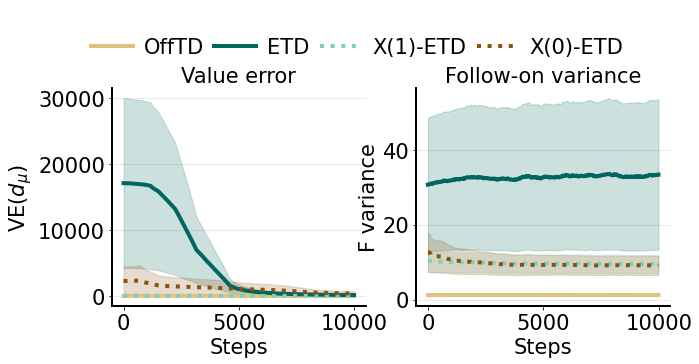

In [ ]:
#@title OffTD/ETD/X(1)-ETD/X(0)-ETD
agents = [
          "OffTD",
          "ETD",
          "X(1)-ETD",
          "X(0)-ETD",
          ]
hyperparams = {"discount": [1.],
               "lambda": [0.],
               "alpha_v": [None],
               "d": [0.4, 0.5, 0.8, 0.9],
               "df": [0.4],#, 0.5, 0.8, 0.9],
               "dz": [0.4],# 0.5, 0.8, 0.9],
               "alpha_f": [None],
               "alpha_z": [0.1],
               "nonlinear_et": [False],
               "clipped": [False],
               "eta": [None],
               "positive_followon": [False],
               "beta": [np.inf],
              }
custom_hyperparams = {
    "OffTD": {"d": [0.5],
    },
    "ETD": {"d": [0.9],
    },
    "X(1)-ETD": {"d": [0.9],
              "df": [0.5],
    },
    "X(0)-ETD": {"d": [0.9],
              "df": [0.5],
    },
}
envs = [
        "FiveStateMDP",
        # "TabularFiveStateMDP"
        ]
seeds = 20
smoothing = 10

number_of_steps = int(1e4)
# stats5 = run(number_of_steps=number_of_steps,
#                                       log_every_steps=1,
#                                       seeds=seeds,
#                                       envs=envs,
#                                       custom_hyperparams=custom_hyperparams,
#                                       hyperparams=hyperparams,
#                                       # verbose=True,
#                                       agents=agents)

for k, env_id in enumerate(envs):
  if env_id == "FiveStateMDP":
    n_params = 3
  elif env_id == "TabularFiveStateMDP":
    n_params = 5
  else:
    n_params = 6
#   import pdb;pdb.set_trace()
  statistics = {
    #   "td_error": {"data": stats["td_error"][k],
    #                          "description": r'$\delta$'
    #                          },
                "value_error": {"data": stats5["value_errors"][k],
                             "y": r'VE($d_\mu$)',
                             'description': "Value error"
                             },
                # "value": {"data": stats["values"][k],
                #              "description": r'$v_w / q_w$'
                #              },
                # "f_td_or_mc_error": {"data": stats["f_td_or_mc_errors"][k],
                #              "description": r'$\delta_F$'
                #              },
                # "f_exp_error": {"data": stats2["f_exp_errors"][k],
                #              "description": r'F bias'
                #              },
                "f_var_error": {"data": stats5["f_var_errors"][k],
                             "y": r'F variance',
                             "description": "Follow-on variance"
                             },
                #   "rewards": {"data": stats_td_lr["rewards"][k],
                #                   "description": "Episode rewards"},
                # #  "ep_timesteps": {"data": stats_td_lr["ep_timesteps"][k],
                # #                   "description": "Episode timesteps"},
                # "return": {"data": stats_td_lr["rewards"][k],
                #              "description": "Episode returns"},
                # "zloss": {"data": stats_td_lr["zloss"][k],
                #              "description": r"$\delta_z$"}
                }

  plot_statistics(env_id=env_id, agents=agents,
                  statistics=statistics,
                  custom_hyperparams=custom_hyperparams,
                  hyperparams=hyperparams,
                  smoothing=smoothing, fontsize=21,
                  legend_loc='lower left',
                  legend_bbox_to_anchor=(.1, 1.),
                  legend_ncol=4,
                  num_ticks=2,
                  cols=2, rows=1,
                  seeds=seeds)